In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import xarray as xr
import random 
import numpy as np
from sklearn.metrics import mean_squared_error

# pytorch
import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Eurac utils
from hython.datasets.preprocess import preprocess, apply_missing_policy, apply_normalization, apply_train_test_split
from hython.datasets.dataset_reader import xarray_to_array, create_dataset
from hython.models.lstm import CustomLSTMModel
from hython.models.CudnnLstmModel import CudnnLstmModel
from hython.train_val import train_val
from hython.metrics import RMSELoss


from hython.datasets.preprocess import reconstruct, missing_gridcell_index
    
from hython.datasets.datasets import LSTMDataset

from hython.sampler import Sampler

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset

import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append('/home/iferrario/dev/differentiable_modelling/tsai/model_code/')
from hydroDL.model import rnn, crit, train

loading package hydroDL


In [4]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(2023)

In [104]:
from pathlib import Path 
ipath = Path('/mnt/CEPH_PROJECTS/InterTwin/Wflow/full_domain/alps1km')
dyn_vars_ds = xr.open_dataset(ipath / 'inmaps_eobs_eobsd_makkink_86400_2015_2019.nc', decode_coords='all',chunks= {"time":100})
static_params_ds = xr.open_dataset(ipath / "staticmaps.nc", decode_coords='all', chunks= {"time":100}).sel(layer=1)
target_ds = xr.open_dataset(ipath / "run_default/output.nc", decode_coords='all', chunks= {"time":100}).sel(layer=1).isel(lat=slice(None, None, -1))
target_ds.dims,dyn_vars_ds.dims, static_params_ds.dims


(Frozen({'lon': 1177, 'lat': 689, 'time': 1825}),
 Frozen({'time': 1826, 'lon': 1177, 'lat': 689}),
 Frozen({'lat': 689, 'lon': 1177, 'time': 12}))

In [9]:
target_ds.data_vars

Data variables:
    soil_moisture       (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    evapotranspiration  (time, lat, lon) float32 nan nan nan nan ... nan nan nan

In [14]:
import glob 
glob.glob('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data')
dyn_vars_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/Dynamic_Data_2000_2015.nc',decode_coords='all', chunks= {"time":100})#.to_dataset(dim='variable')
static_params_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/staticmaps.nc',decode_coords='all', chunks= {"time":100}).sel(layer=1)#.to_dataset(dim='variable')
target_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/Target_train_et_sm_2000_2015.nc',decode_coords='all', chunks= {"time":100}).isel(lat=slice(None, None, -1))
dyn_vars_ds.dims, static_params_ds.dims, target_ds.dims

(Frozen({'time': 5844, 'lat': 214, 'lon': 245}),
 Frozen({'lat': 214, 'lon': 245, 'time': 12}),
 Frozen({'lon': 245, 'lat': 214, 'time': 5844}))

## Preparation

In [107]:
timeslice = slice("2016-01-01","2020-12-31")

dyn_vars_ds = dyn_vars_ds.sel(time=timeslice)
target_ds = target_ds.sel(time=timeslice)
target_ds.dims,dyn_vars_ds.dims

(Frozen({'lon': 1177, 'lat': 689, 'time': 1461}),
 Frozen({'time': 1461, 'lon': 1177, 'lat': 689}))

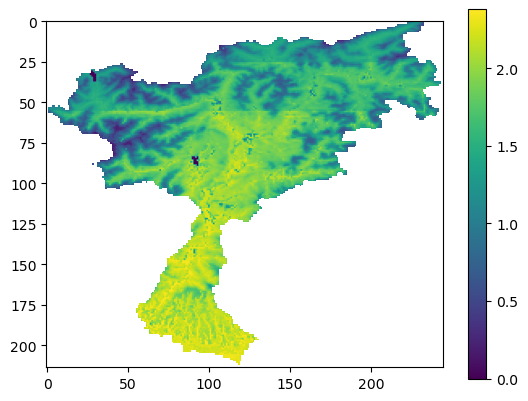

In [17]:
plt.imshow(target_ds.evapotranspiration.isel(time=1000).values)
plt.colorbar()

In [7]:
# latslice = slice(46.8,46.4)
# lonslice =   slice(10,11.2)

# dyn_vars_ds = dyn_vars_ds.sel(lat=latslice, lon = lonslice )
# static_params_ds = static_params_ds.sel(lat=latslice, lon = lonslice )
# target_ds = target_ds.sel(lat=slice(46.4,46.8), lon = lonslice )
# target_ds.dims,dyn_vars_ds.dims, static_params_ds.dims

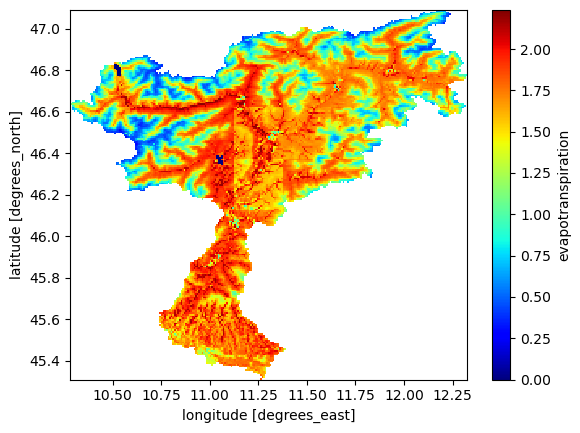

In [18]:
target_ds.mean(dim = "time").evapotranspiration.plot(cmap = "jet")

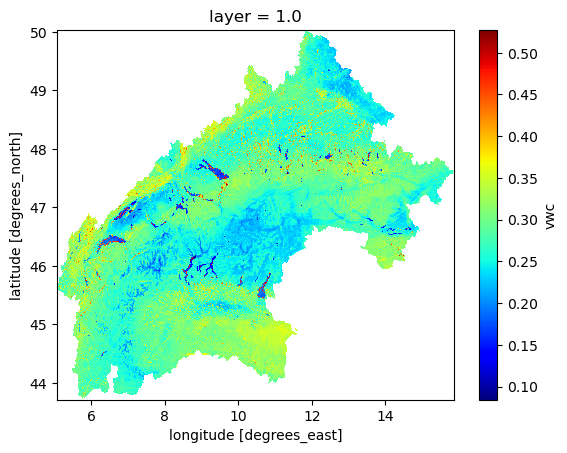

In [96]:
target_ds.mean(dim = "time").vwc.plot(cmap = "jet")

In [19]:
mask_lakes = (target_ds.mean(dim = "time").evapotranspiration == 0).astype(np.bool_)

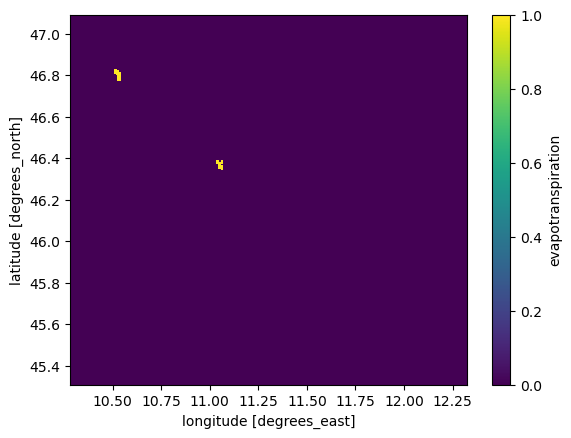

In [20]:
mask_lakes.plot()

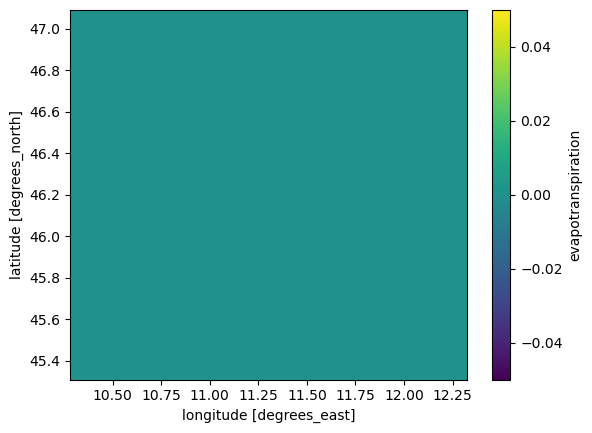

In [21]:
(target_ds < 0).any(dim=["time"]).evapotranspiration.plot()

In [79]:
mask_lakes = (np.isnan(target_ds)).any(dim=["time"]).soil_moisture

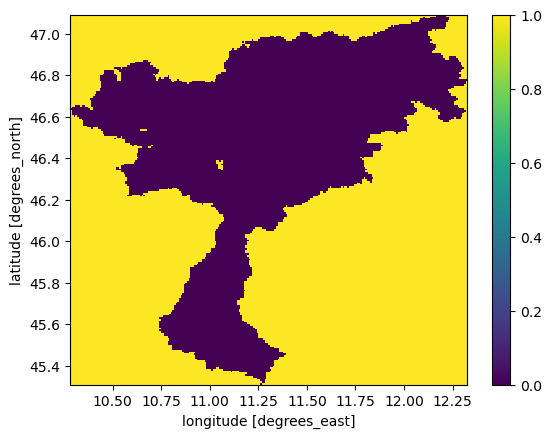

In [78]:
(mask_lakes + (np.isnan(target_ds)).any(dim=["time"]).soil_moisture).plot()

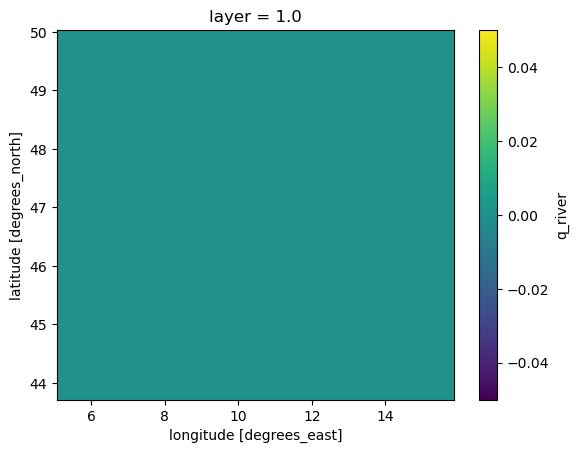

In [69]:
(target_ds < 0).any(dim=["time"]).q_river.plot()

In [28]:
dynamic_names = ["precip", "pet", "temp"]
static_names = [ 'M', 'thetaS', 'RootingDepth', 'Kext', 'Sl', 'Swood', 'TT', 'KsatHorFrac'] 
target_names = [ "soil_moisture"] # "vwc"] #,  "actevap", "q_river"]

In [23]:
dim_space = list(dyn_vars_ds.dims.values())[1:] # lon, lat
dim_time = list(dyn_vars_ds.dims.values())[0] # tim
dim_space, dim_time

([214, 245], 5844)

In [200]:
intervals = (3, 3)
train_origin = (0, 0)
valid_origin =  (3, 3)
test_origin =  (9, 9)

### Preprocess

In [80]:
# mask lakes
remove_lakes = True
if remove_lakes:
    target_ds = target_ds.where(~mask_lakes, np.nan)
    dyn_vars_ds = dyn_vars_ds.where(~mask_lakes, np.nan)
    static_params_ds = static_params_ds.where(~mask_lakes, np.nan)


#target_ds.actevap.mean(dim="time").plot(cmap="jet")

In [207]:
Xd, Xs, Y, dims = preprocess(dyn_vars_ds, 
                       static_params_ds, 
                       target_ds, 
                       dynamic_name = dynamic_names,
                       static_name = static_names, 
                       target_name = target_names, 
                       #sampler = Sampler(intervals = intervals,
                       #                  origin = train_origin)
                       )


dynamic:  (52430, 5844, 3)  => (GRIDCELL, TIME, FEATURE)
static:  (52430, 8)  => (GRIDCELL, FEATURE)
target:  (52430, 5844, 1)  => (GRIDCELL, TIME, TARGET)


In [82]:
Xd_valid, Xs_valid, Y_valid, dims_valid = preprocess(dyn_vars_ds, 
                       static_params_ds, 
                       target_ds, 
                       dynamic_name = dynamic_names,
                       static_name = static_names, 
                       target_name = target_names, 
                       sampler = Sampler(intervals = intervals,
                                         origin = valid_origin)
                       )

sampling reduced dims (lat, lon): from  [214, 245]  to  [43, 49]


dynamic:  (2107, 5844, 3)  => (GRIDCELL, TIME, FEATURE)
static:  (2107, 8)  => (GRIDCELL, FEATURE)
target:  (2107, 5844, 1)  => (GRIDCELL, TIME, TARGET)


In [83]:
dims_valid

{'orig': [214, 245, 5844], 'sampled_dims': [43, 49, 5844]}

In [116]:
# Xd_test, Xs_test, Y_test, dims_test = preprocess(dyn_vars_ds, 
#                        static_params_ds, 
#                        target_ds, 
#                        dynamic_name = dynamic_names,
#                        static_name = static_names, 
#                        target_name = target_names, 
#                        sampler = Sampler(intervals = intervals,
#                                          origin = test_origin)
#                        )

In [84]:
Xd.shape

(2107, 5844, 3)

### Correct negative values in actevap 

In [85]:
if (Y < 0).any():
    print("found negative values")
    Y = np.where(Y < 0, 0, Y)

### Remove missing

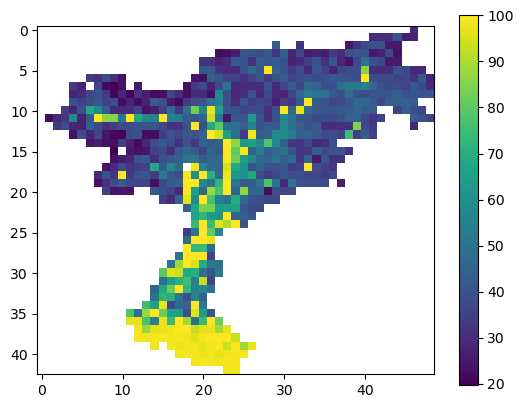

In [86]:
plt.imshow(
    Y[:,0].reshape(*dims["sampled_dims"][:2])
    )
plt.colorbar()

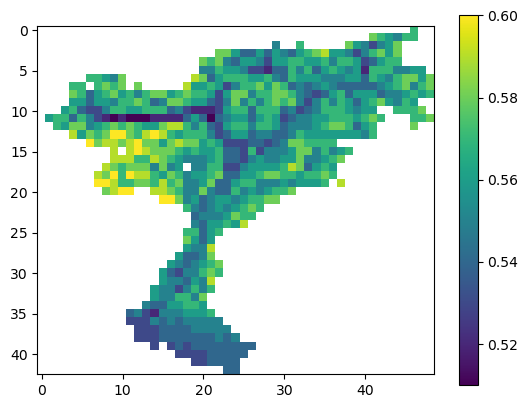

In [87]:
plt.imshow(
    Xd[:,0,1].reshape(*dims["sampled_dims"][:2])
    )
plt.colorbar()

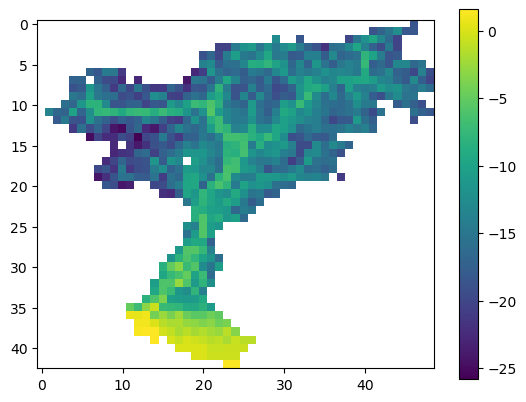

In [88]:
plt.imshow(Xd[:,0, 2].reshape(*dims["sampled_dims"][:2]))
plt.colorbar()

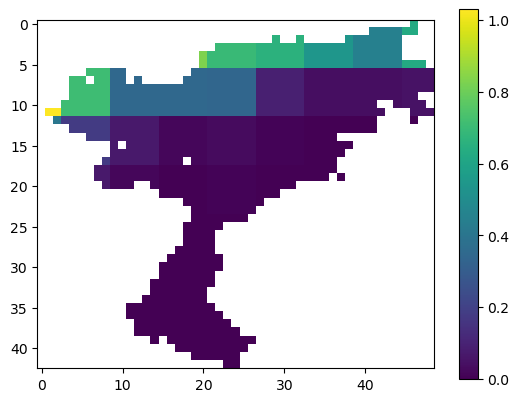

In [89]:
plt.imshow(Xd[:,0, 0].reshape(*dims["sampled_dims"][:2]))
plt.colorbar()

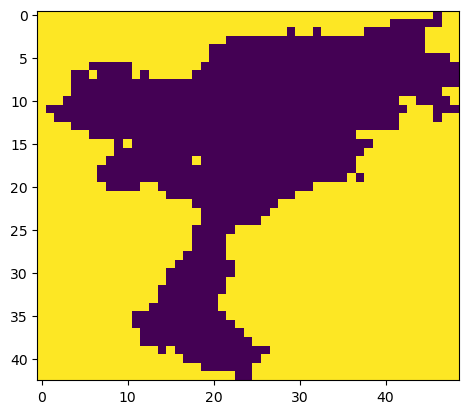

In [90]:
# find indices of missing values
idx = missing_gridcell_index(Xs)
plt.imshow(idx.reshape(*dims["sampled_dims"][:2]))

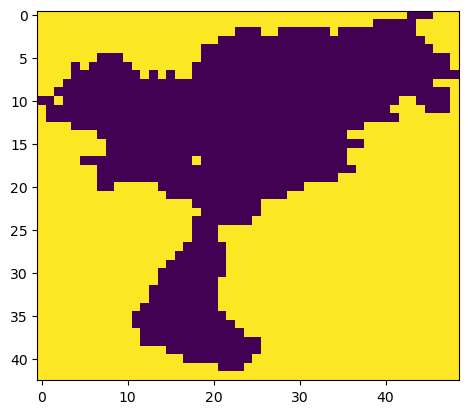

In [91]:
# find indices of missing values
idx_valid = missing_gridcell_index(Xs_valid)
plt.imshow(idx_valid.reshape(*dims["sampled_dims"][:2]))

In [92]:
# remove missing from all datasets, do training
# Xd_out = Xd[~idx].copy()

# Xd_out.shape

# # reconstruct
# Xd_again = reconstruct(Xd_out, Xd.shape, idx)

# plt.imshow(Xd_again[:,0,2].reshape(*dims["sampled_dims"][:2])  - Xd[:, 0, 2].reshape(*dims["sampled_dims"][:2]))
# plt.colorbar()


In [93]:
Y_valid.shape

(2107, 5844, 1)

In [94]:
Xd_clean = Xd[~idx]
Xs_clean = Xs[~idx]
Y_clean = Y[~idx]

Xd_valid_clean = Xd_valid[~idx_valid]
Xs_valid_clean = Xs_valid[~idx_valid]
Y_valid_clean = Y_valid[~idx_valid]

In [95]:
Xd.shape, Xd_clean.shape, Xs_clean.shape, Y_clean.shape

((2107, 5844, 3), (799, 5844, 3), (799, 8), (799, 5844, 1))

In [96]:
np.isnan(Xd_clean).any(), np.isnan(Xs_clean).any(), np.isnan(Y_clean).any(),np.isnan(Xd_valid_clean).any(), np.isnan(Xs_valid_clean).any(), np.isnan(Y_valid_clean).any()

(False, False, False, False, False, False)

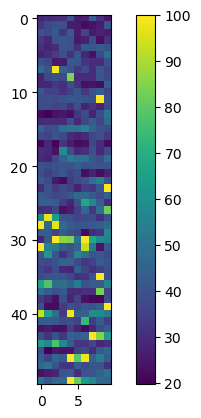

In [97]:
plt.imshow(Y_clean[:500,1,0].reshape((50,10)))
plt.colorbar()

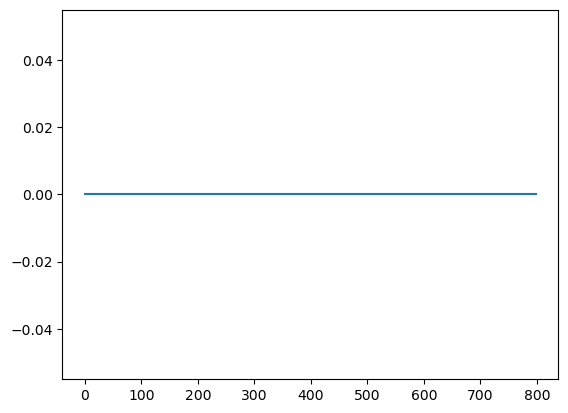

In [98]:
plt.plot(np.any(np.isnan(Y_clean),axis=(1,2)))

In [99]:
reconstruct(Y_clean, Y.shape, idx)

array([[[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       ...,

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]]])

In [100]:
for i in range(100):
    if np.isnan(Y_clean[i,:,0]).any():
        print(i)
        plt.plot(Y_clean[i,:,0])

In [101]:
Xd_clean.shape, Xs_valid_clean.shape

((799, 5844, 3), (803, 8))

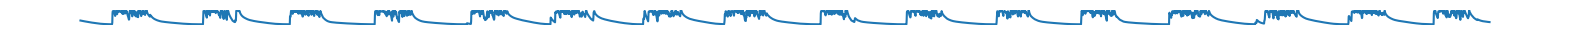

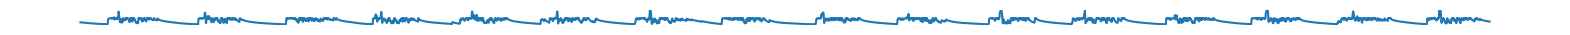

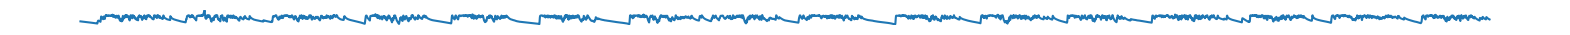

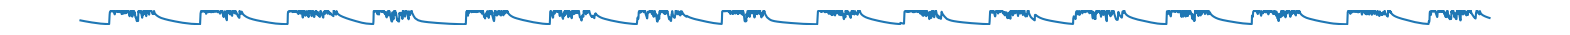

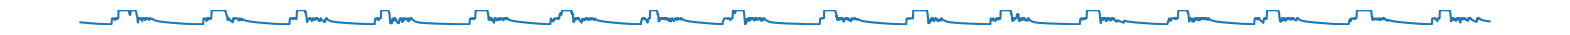

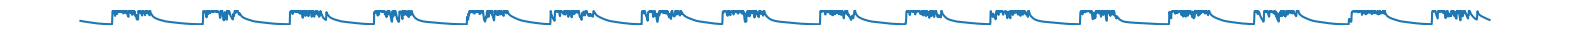

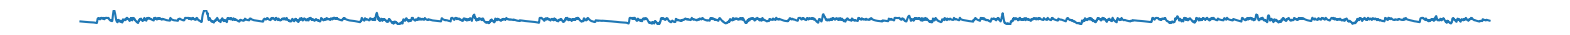

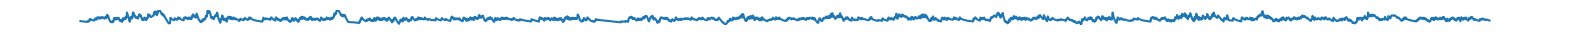

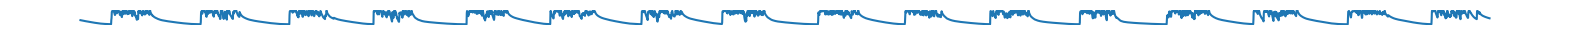

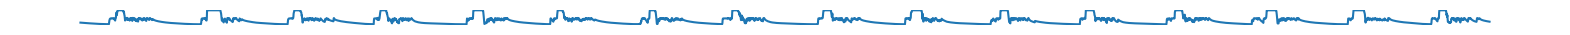

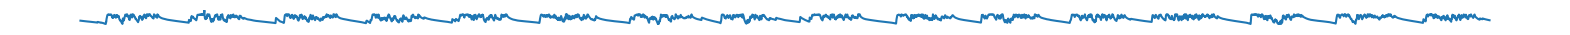

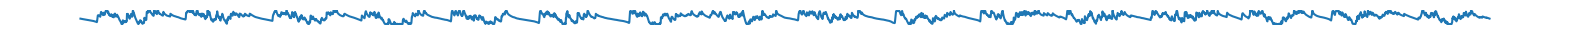

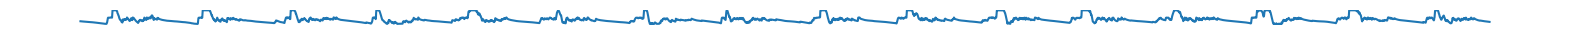

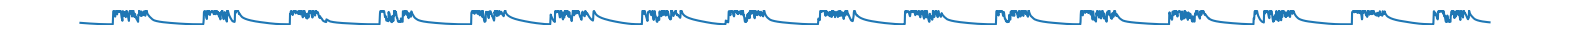

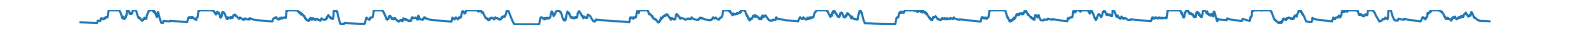

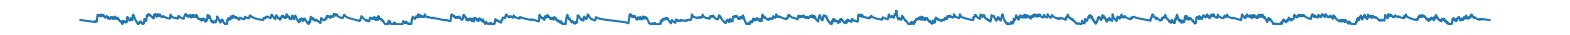

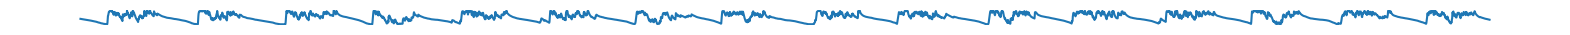

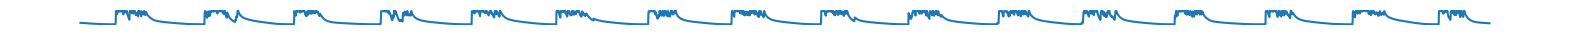

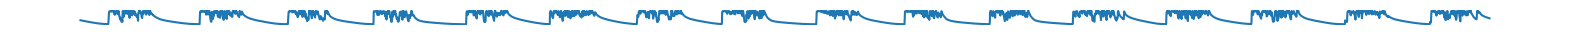

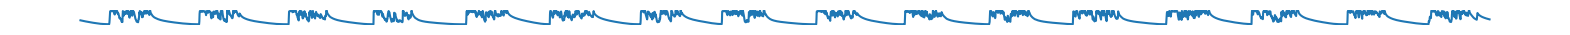

In [102]:
for i in range(0, 200, 10):
    plt.figure(figsize=(20,0.2))
    ax = plt.plot(Y_clean[i,:,0])
    plt.axis('off')

### Apply normalization

In [59]:
Xd_clean, d_m, d_std = apply_normalization(Xd_clean, type = "time", how ='standard')
Xs_clean, s_m, s_std = apply_normalization(Xs_clean, type = "space", how ='standard')
#Y_clean, y_m, y_std = apply_normalization(Y_clean, type = "spacetime", how ='standard')

In [103]:
s_std.shape,d_std.shape

NameError: name 's_std' is not defined

In [61]:
Xd_valid_clean = apply_normalization(Xd_valid_clean, type = "time", how ='standard', m = d_m, std = d_std)
Xs_valid_clean = apply_normalization(Xs_valid_clean, type = "space", how ='standard', m = s_m, std = s_std)
#Y_valid_clean = apply_normalization(Y_valid_clean, type = "spacetime", how ='standard', m = y_m, std = y_std)


ValueError: operands could not be broadcast together with shapes (3796,1461,3) (3795,1,3) 

In [104]:
np.isnan(Xd_clean).any(), np.isnan(Xs_clean).any(), np.isnan(Y_clean).any(),np.isnan(Xd_valid_clean).any(), np.isnan(Xs_valid_clean).any(), np.isnan(Y_valid_clean).any()

(False, False, False, False, False, False)

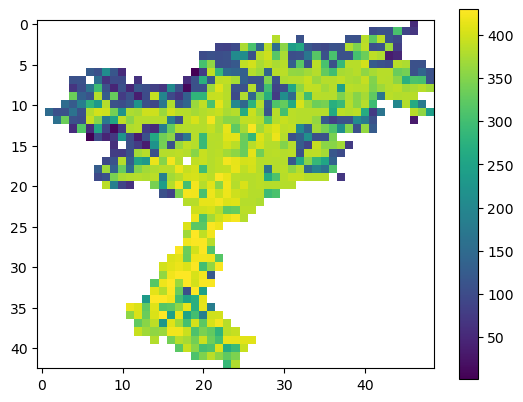

In [105]:
plt.imshow(reconstruct(Xs_clean, Xs.shape, idx)[:,2].reshape(*dims["sampled_dims"][:2]))
plt.colorbar()

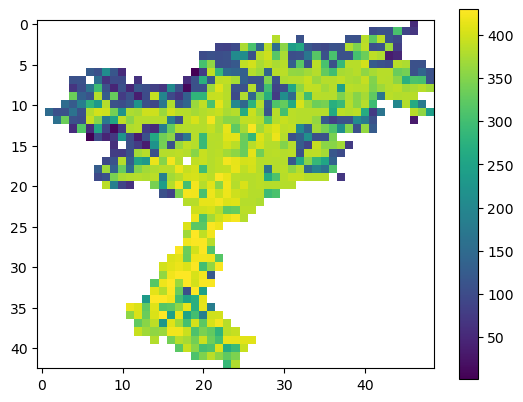

In [106]:
plt.imshow(Xs[:,2].reshape(*dims["sampled_dims"][:2]))
plt.colorbar()

In [107]:

policy_missing = {
    "dynamic": {
            "replace": 0,
            "drop": missing_gridcell_index # drop gridcell where the time series has at least 1 missing
    },
    "static": {
            "replace": 0,
            "drop": missing_gridcell_index
    },
    "target": {
            "replace": 0,
            "drop": missing_gridcell_index # drop gridcell where the time series has at least 1 missing
    }
}

# Xd, Xs, Y = apply_missing_policy(Xd, Xs, Y, policy_missing = policy_missing )
# Xd_valid, Xs_valid, Y_valid = apply_missing_policy(Xd_valid, Xs_valid, Y_valid, policy_missing = policy_missing )

### Preparing data loader

In [108]:
nx = Xd.shape[-1] + Xs.shape[-1]
ny = Y.shape[-1]
nx, ny

(11, 1)

In [155]:
batch_size =  256 # int(512 / 4)

In [156]:
#dataset = TensorDataset(*list(map(torch.Tensor,[Xd, Xs, Y])))
#dataset

In [157]:
train_dataset = LSTMDataset(Xd_clean, Y_clean, Xs_clean, 120)

In [158]:
val_dataset = LSTMDataset(Xd_valid_clean, Y_valid_clean, Xs_valid_clean, 120)

In [159]:
#train_size = int(0.8 * len(dataset))
#val_size = len(dataset) - train_size
#train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) # select random pixels

In [160]:
# PyTorch DataLoader
#data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [161]:
# Create the dataset and return DataLoader
#train_loader2, val_loader2  = create_dataset(dyn_vars_ds, 
#                                           static_params_ds, 
#                                           target_ds,
#                                           batch_size=64,
#                                           time_steps= len(dyn_vars_ds.time), #1095, #time_steps=365 5844
#                                           dyn_vars_names= dynamic_names,
#                                           static_params_names=static_names, #[ 'M', 'thetaS', 'RootingDepth', 'Kext', 'Sl', 'Swood', 'TT', 'KsatHorFrac'],
#                                           target_names=target_names) # ['vwc_percroot', 'soil_moisture']

In [162]:
# Invistigate the dataset 
for x1, x2, y in train_loader:
    print(x1.shape, x1.dtype)
    print(x2.shape, x2.dtype)
    print(y.shape, y.dtype)
    break

torch.Size([256, 5844, 3]) torch.float32
torch.Size([256, 8]) torch.float32
torch.Size([256, 5844, 1]) torch.float32


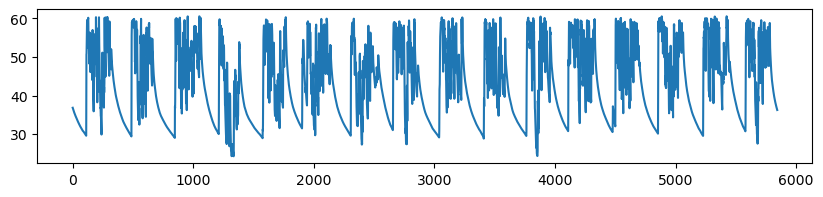

In [163]:
plt.figure(figsize= (10, 2))
plt.plot(y[12, :, 0])

### Setting up model

In [164]:
hidden_size = 128

model_params={
    "input_size": 3, #number of dynamic predictors - user_input
    "hidden_size": hidden_size, # user_input
    "output_size": 1, # number_target - user_input
    "number_static_predictors": len(static_names), #number of static parameters - user_input 

}


## The used device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CustomLSTMModel(model_params)
#model = CudnnLstmModel(nx = nx, ny =  ny, hiddenSize =  hidden_size)
model = model.to(device)
model


set_seed(2023)

def mse_metric(output, target):
    metric_epoch = mean_squared_error(output, target, squared=False)
    return metric_epoch

# Training and validation 
path2models= "./checkpoints" #./output/kaggle/working/AI4EO/models
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
## Where to save the trained models weights 
## Set the optimization algorithms and learning rate
opt = optim.Adam(model.parameters(), lr=1e-2)

## Set the loss function
loss_fn = nn.MSELoss()

## Set the metric function - here using the same loss function 
metric_fn = mse_metric #nn.MSELoss()

## Set the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=15)


In [165]:

epochs = 200

## Set the training parameters
params_train={
    "num_epochs": epochs,
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt"

}


type(model)

hython.models.lstm.CustomLSTMModel

In [166]:
model

CustomLSTMModel(
  (lstm): LSTM(3, 128, batch_first=True, dropout=0.2)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)

## Running

### Soil Moisture 

In [167]:
#lossFun_PF = crit.RmseLoss()
#model = train.trainModel(
#    model, 
#    Xd, # gridcell x time x forcings
#    Y, # gridcell x time x out
#    Xs, # gridcell x VICpar
#    lossFun_PF, 
#    nEpoch=params_train["num_epochs"], 
#    miniBatch=[100, 60], 
#    saveEpoch=50, 
#    saveFolder="./")

In [169]:
model, sm_loss_history ,sm_metric_history = train_val(model, params_train)

Epoch 0/199, current lr=0.01
train loss: 109.32378387451172, train metric: 19.38880157470703
val loss: 168.10311889648438, val metric: 19.259618759155273
----------
Epoch 1/199, current lr=0.01
train loss: 114.53339385986328, train metric: 19.15562629699707
val loss: 126.6918716430664, val metric: 19.488807678222656
----------
Epoch 2/199, current lr=0.01
train loss: 103.70927429199219, train metric: 18.822561264038086
val loss: 122.80081939697266, val metric: 18.17790985107422
----------
Epoch 3/199, current lr=0.01
train loss: 110.69715881347656, train metric: 18.612232208251953
val loss: 108.2557144165039, val metric: 17.471094131469727
----------
Epoch 4/199, current lr=0.01
train loss: 119.71930694580078, train metric: 19.660776138305664
val loss: 130.96612548828125, val metric: 18.279319763183594
----------
Epoch 5/199, current lr=0.01
train loss: 91.71739196777344, train metric: 17.963716506958008
val loss: 95.99247741699219, val metric: 17.27550506591797
----------
Epoch 6/199,

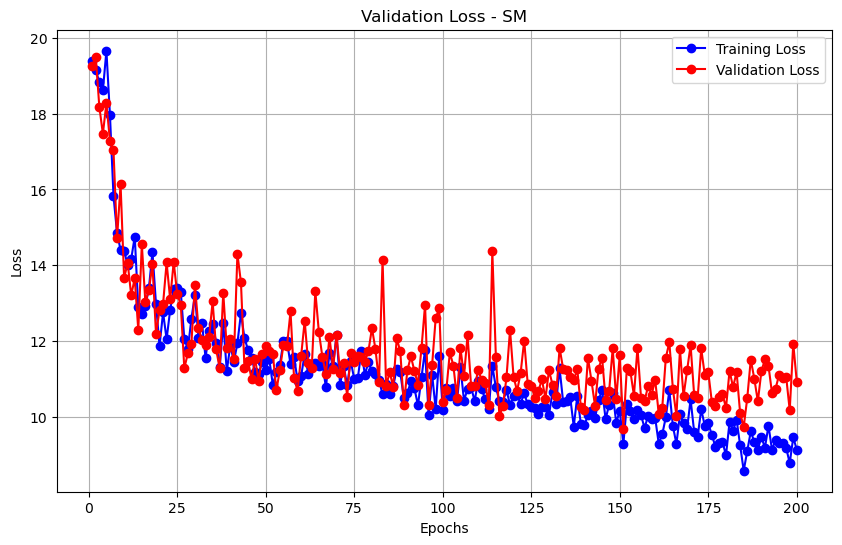

In [170]:
import matplotlib.pyplot as plt
# Extract the loss values
train_loss = sm_metric_history['train']
val_loss = sm_metric_history['val']

# Create a list of epochs for the x-axis (e.g., [1, 2, 3, ..., 100])
epochs = list(range(1,params_train["num_epochs"] + 1))

# Create the train and validation loss plots
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Validation Loss - SM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [185]:
torch.save(model.state_dict(),params_train["path2weights"])


In [ ]:
model.load_state_dict(torch.load(params_train["path2weights"]))

<All keys matched successfully>

In [192]:
model= model.to('cuda:0')
#model= model.to('cpu')

In [186]:
it = iter(train_loader)

In [187]:
din, static, val = next(it)
din.shape, static.shape, val.shape

(torch.Size([256, 5844, 3]), torch.Size([256, 8]), torch.Size([256, 5844, 1]))

In [188]:
# plt.scatter(model(din.to(device), static.to(device)).detach().cpu().numpy()[10,:,0], val[10,:,0])

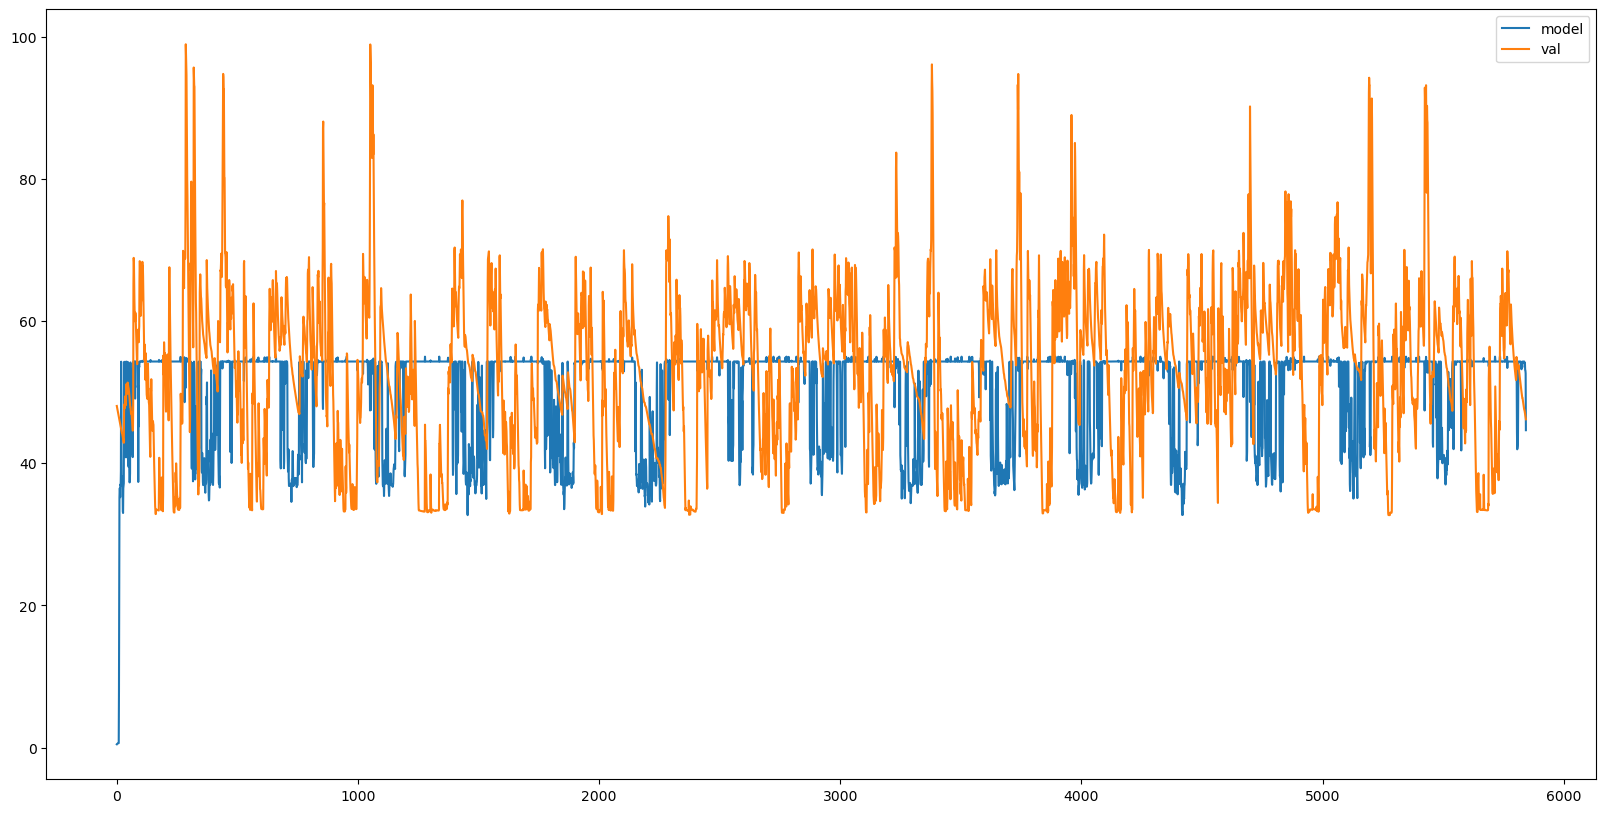

In [190]:
plt.figure(figsize=(20,10)) 
plt.plot(model(din, static).detach().cpu().numpy()[3,:,0], label ="model")
plt.plot(val[3,:,0], label="val")
plt.legend()

In [220]:
arr = []
for i in range(0,Xd.shape[0],100):
    print(i)

    d = torch.Tensor(Xd[i:(i+100)]).to("cuda:0")
    
    if isinstance(model, rnn.CudnnLstmModel):
        s = torch.Tensor(Xs[i:(i+100)]).unsqueeze(1).expand(-1, d.shape[1], -1)
        x0 = torch.cat( (d,s ), -1).to("cuda:0")
        arr.append(
            model(x0).detach().cpu().numpy()
            )
    else:
        s = torch.Tensor(Xs[i:(i+100)]).to("cuda:0")
        arr.append(
            model(d, s).detach().cpu().numpy()
            )

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [221]:
dims, Xd.shape

({'orig': [214, 245, 5844]}, (52430, 5844, 3))

In [222]:
res = np.vstack(arr)
res.shape, Xd.shape,dims

((52430, 5844, 1), (52430, 5844, 3), {'orig': [214, 245, 5844]})

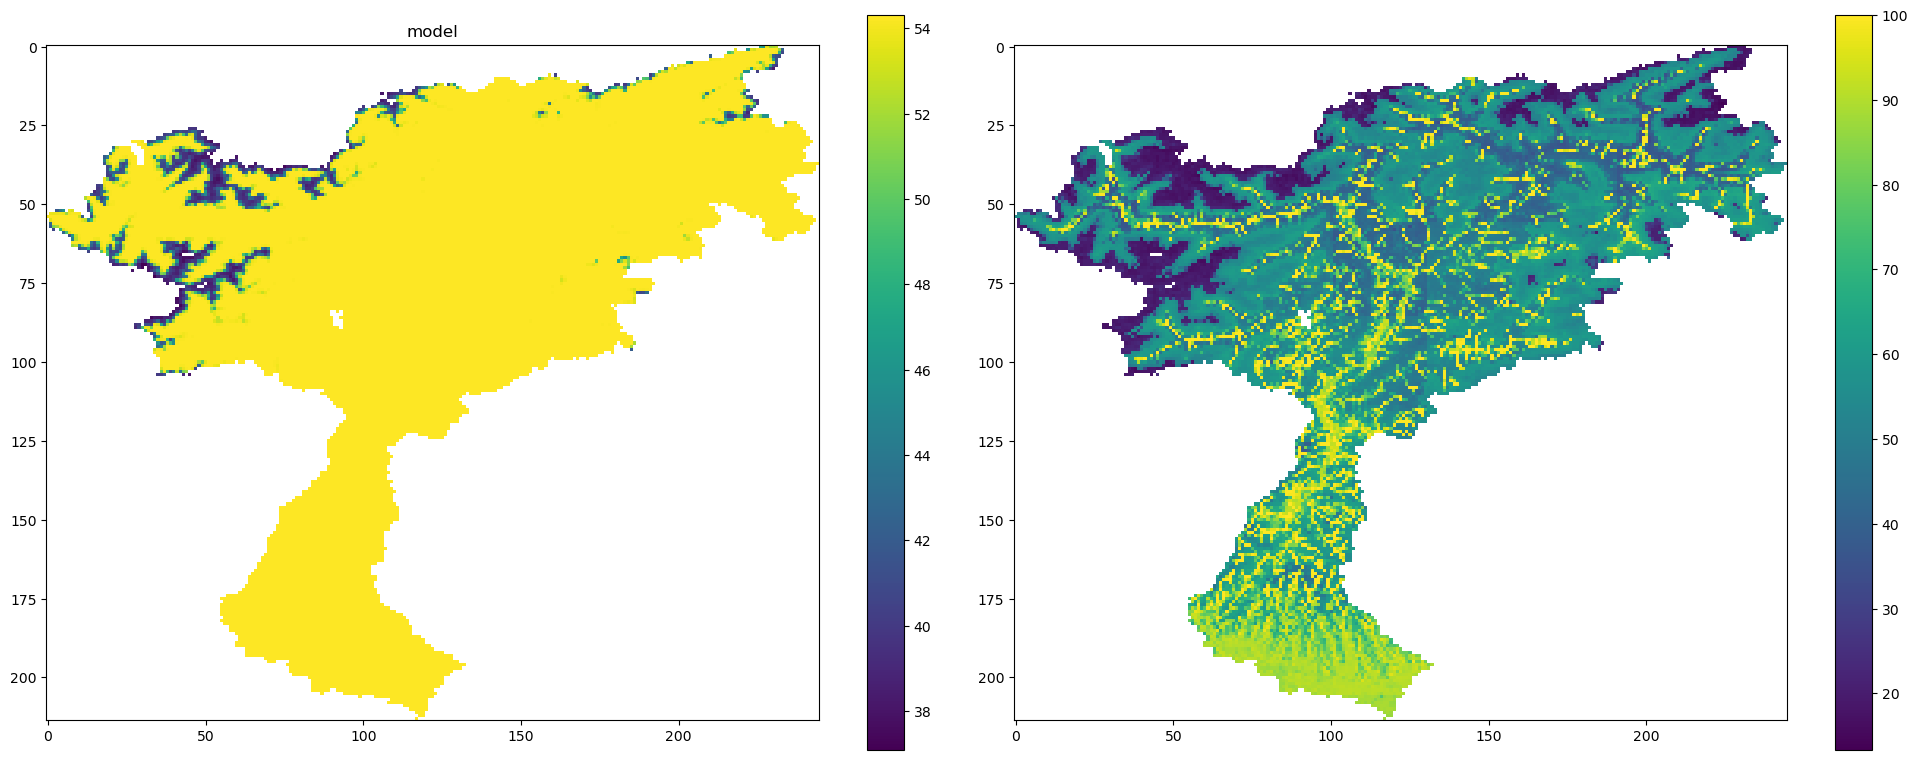

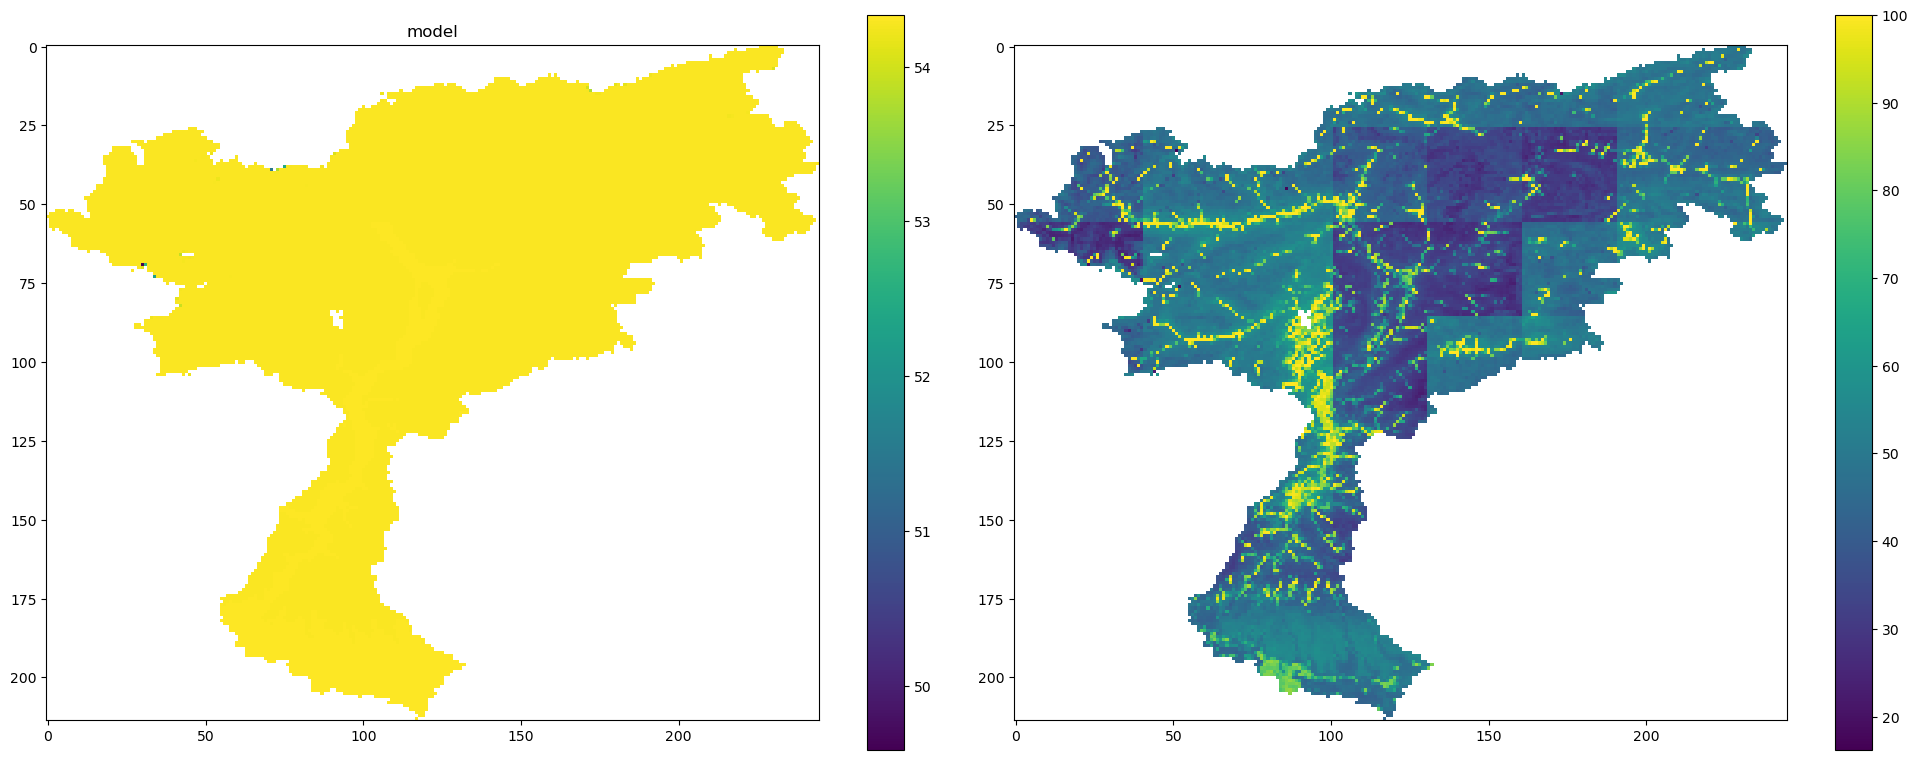

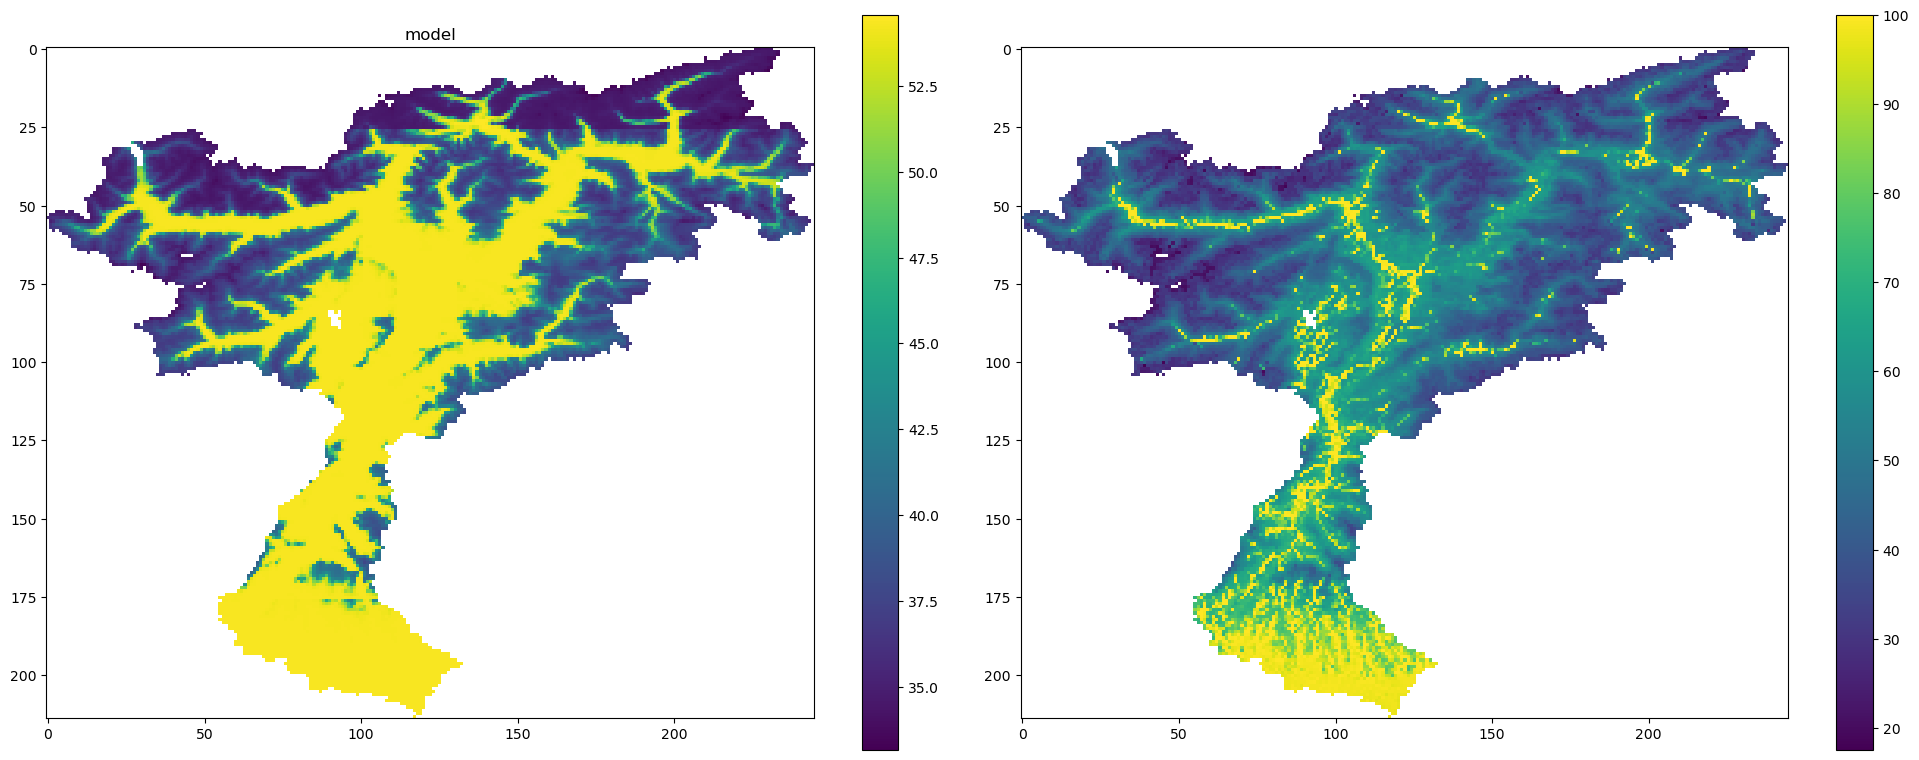

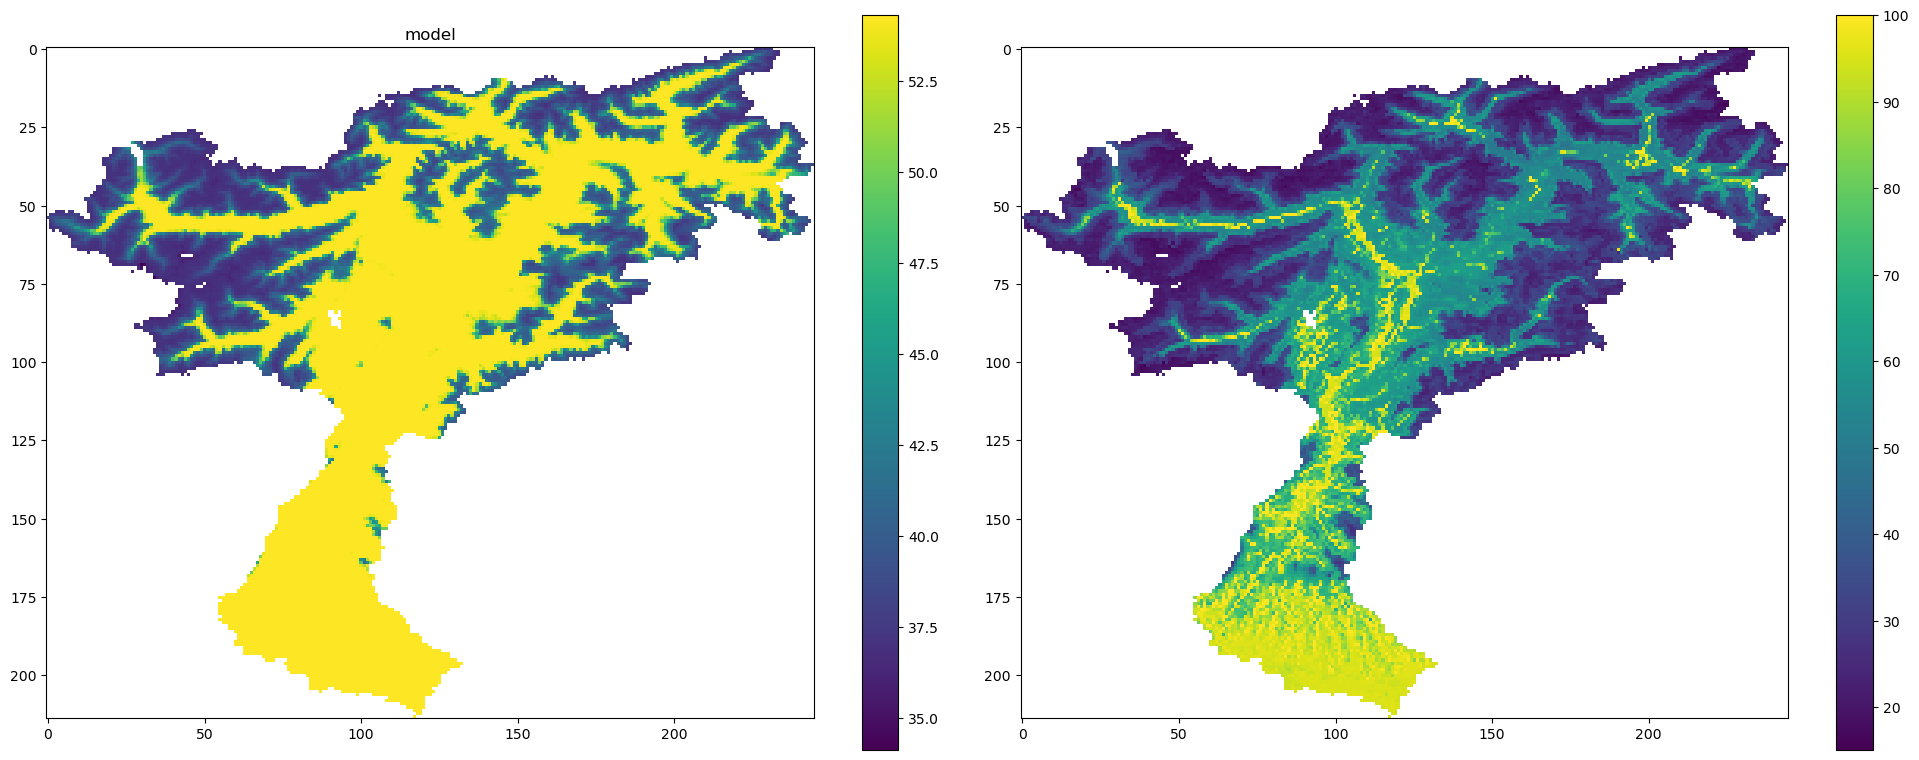

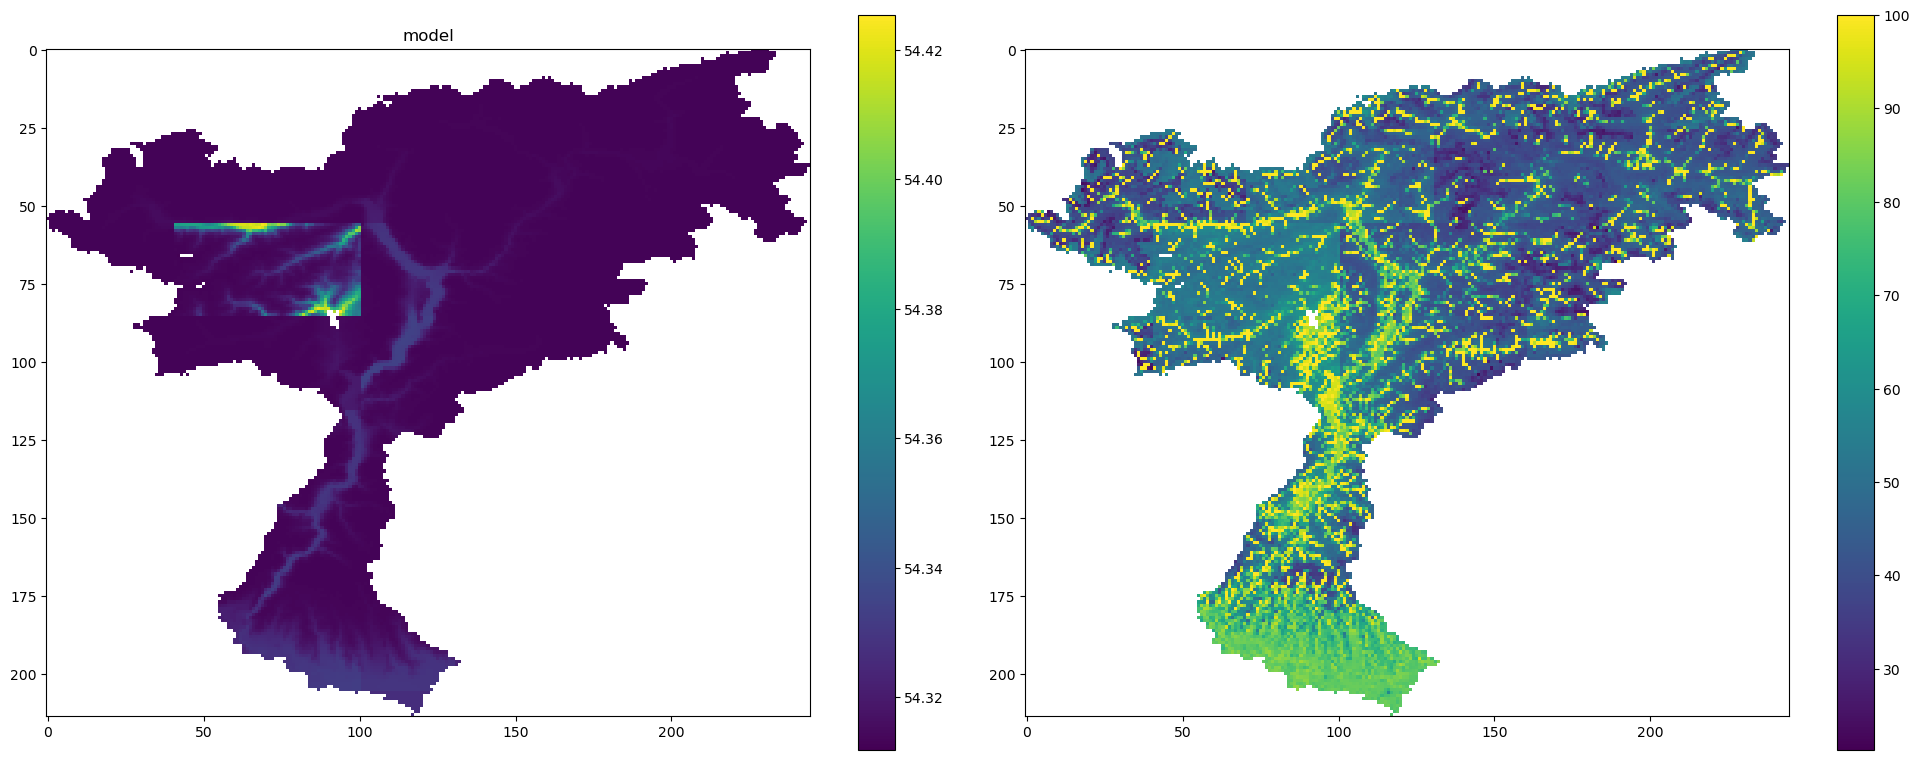

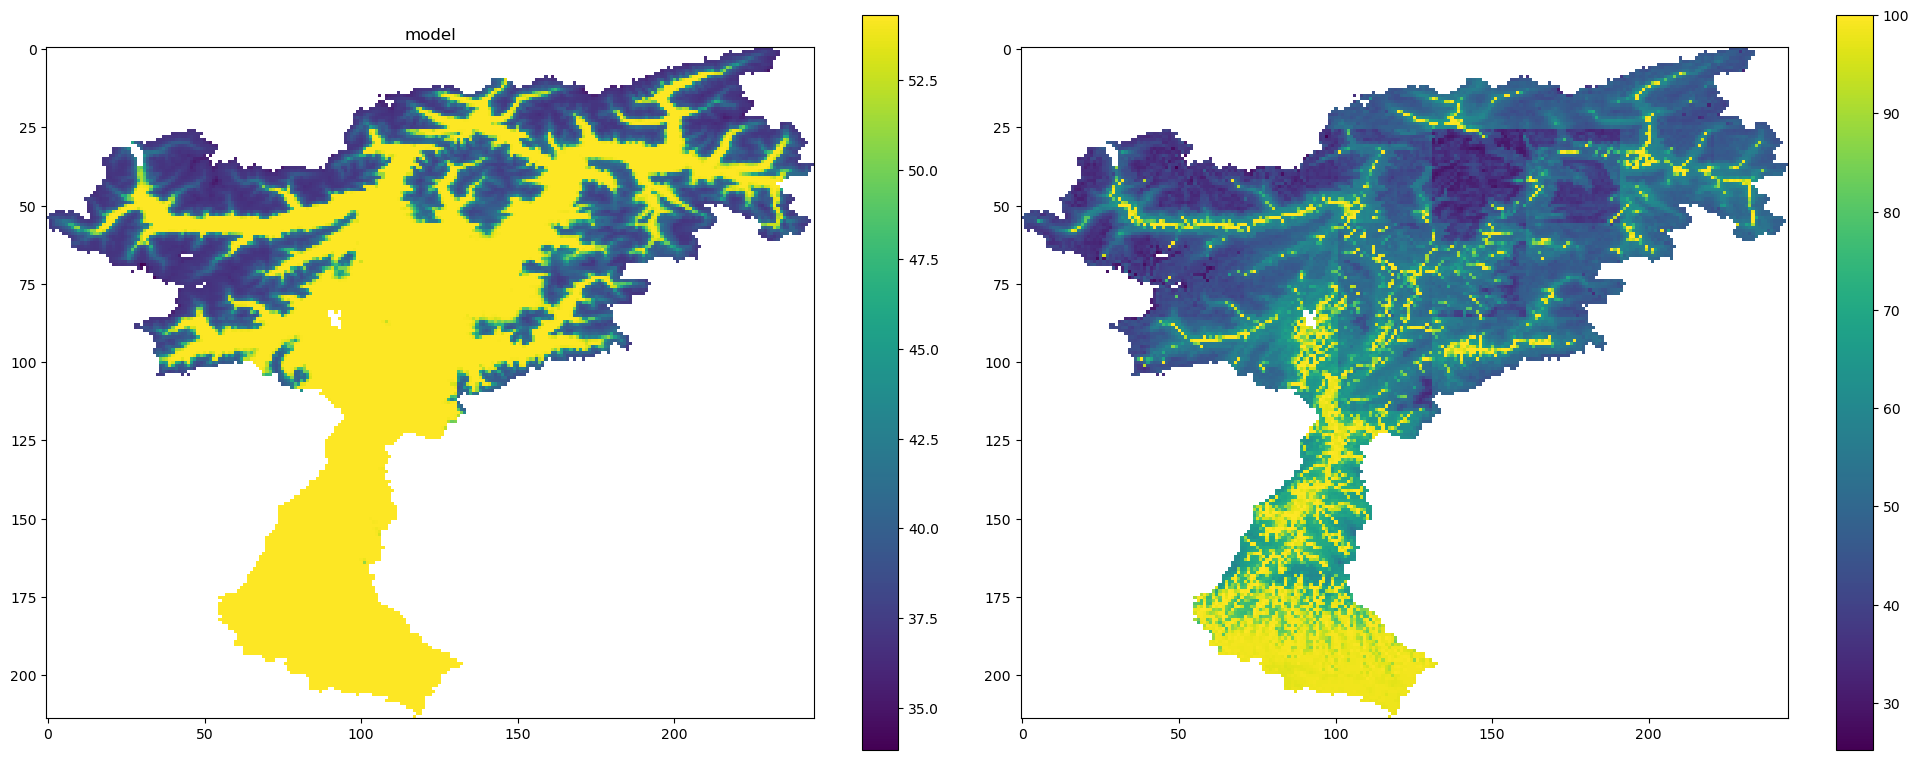

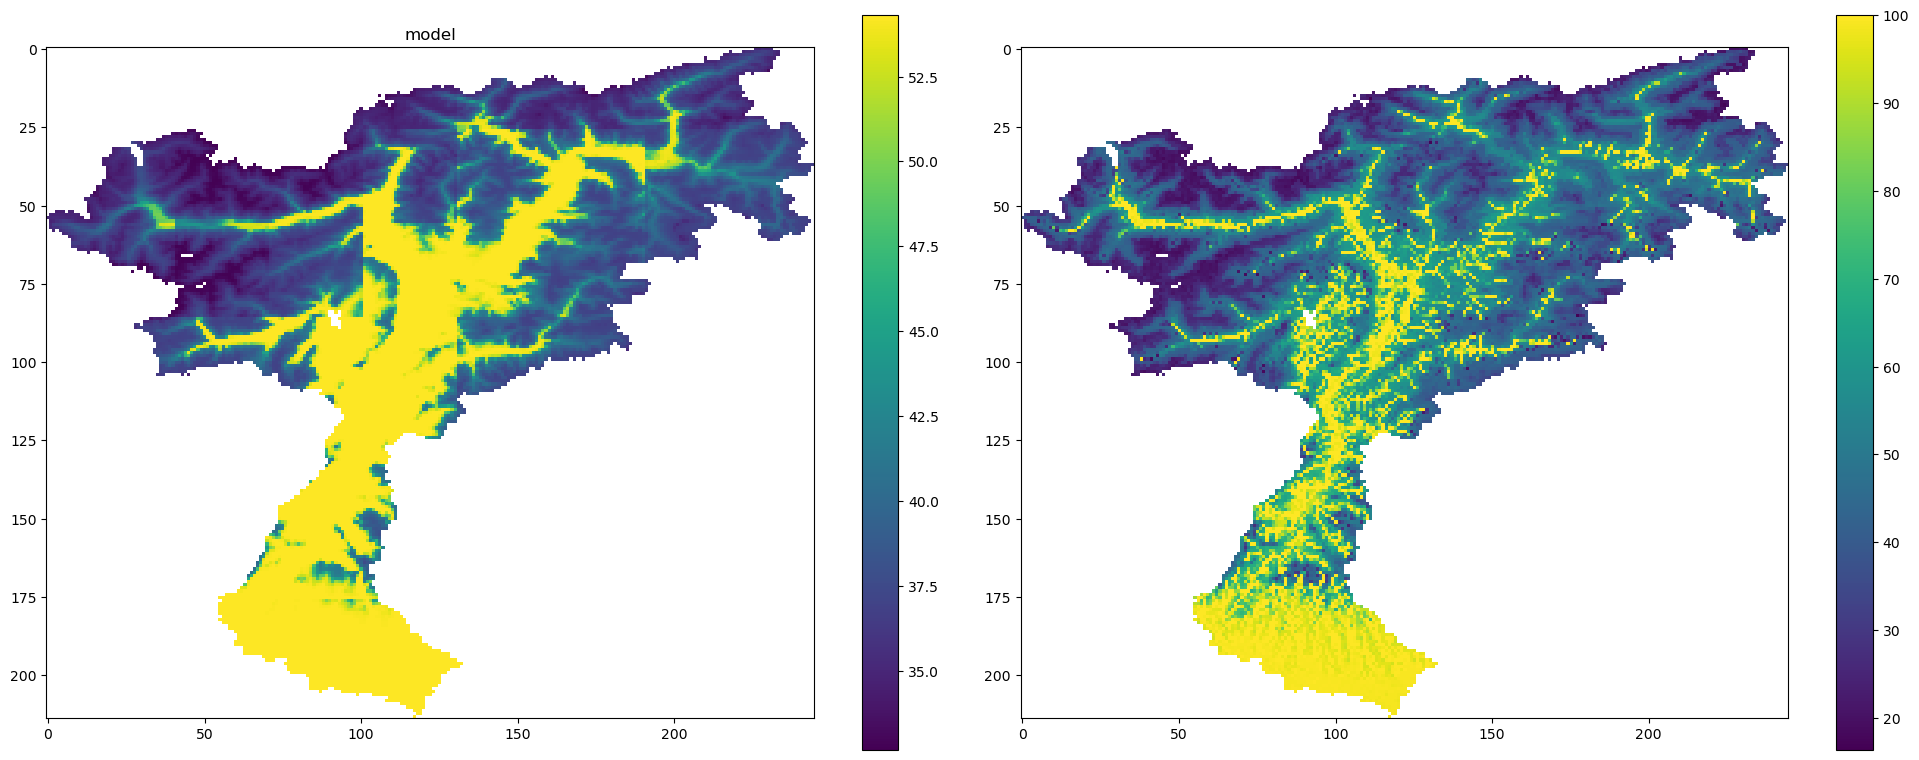

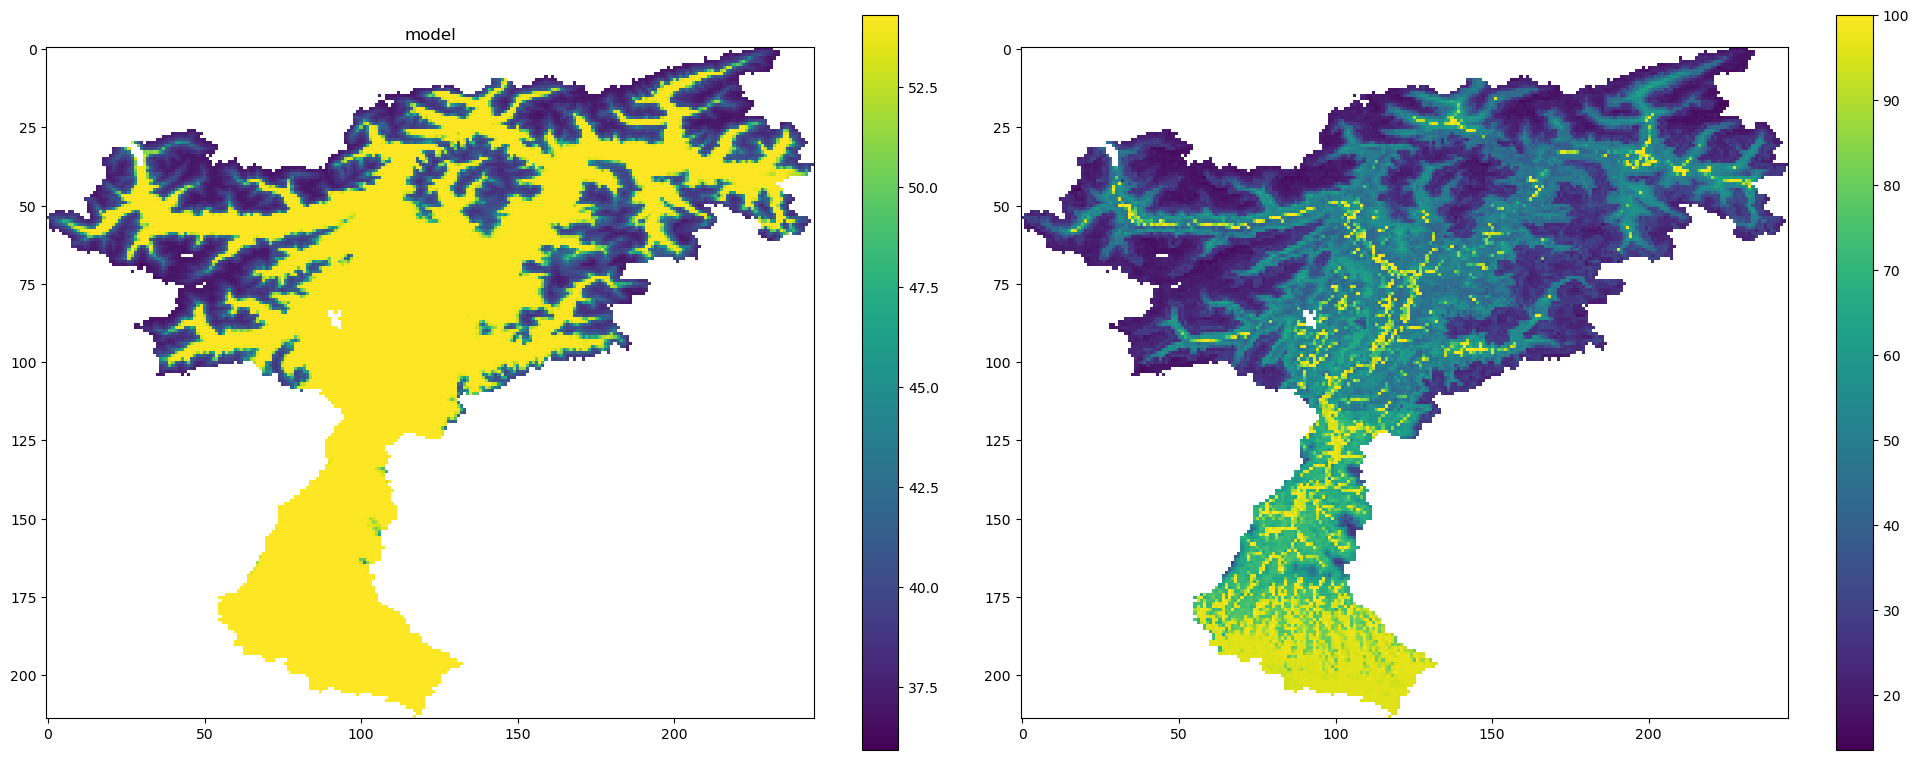

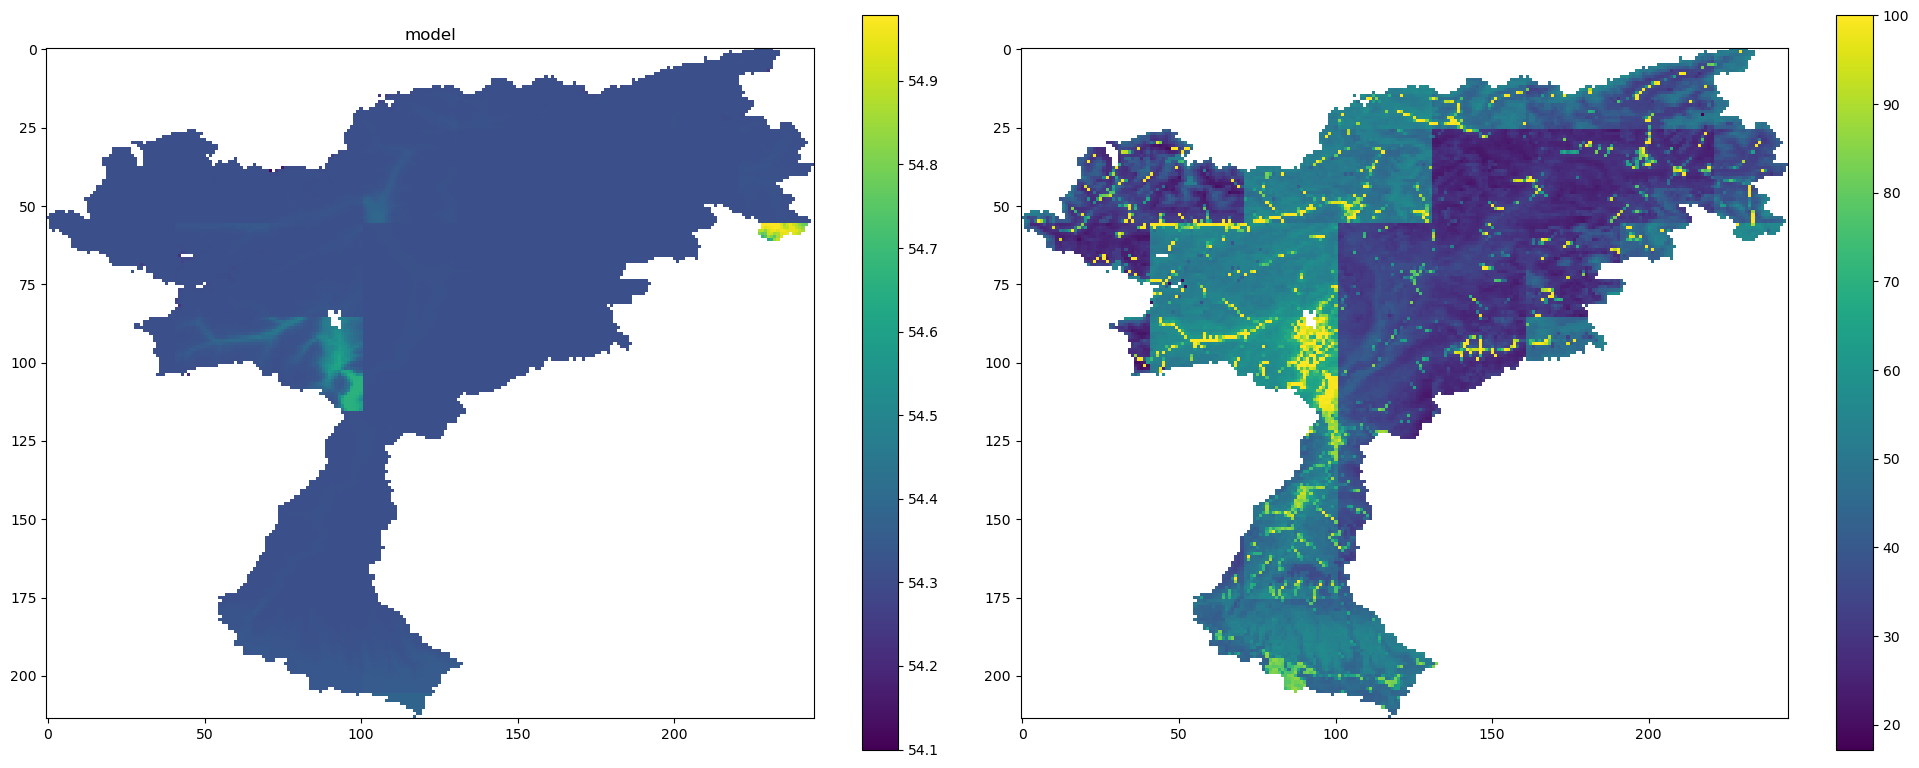

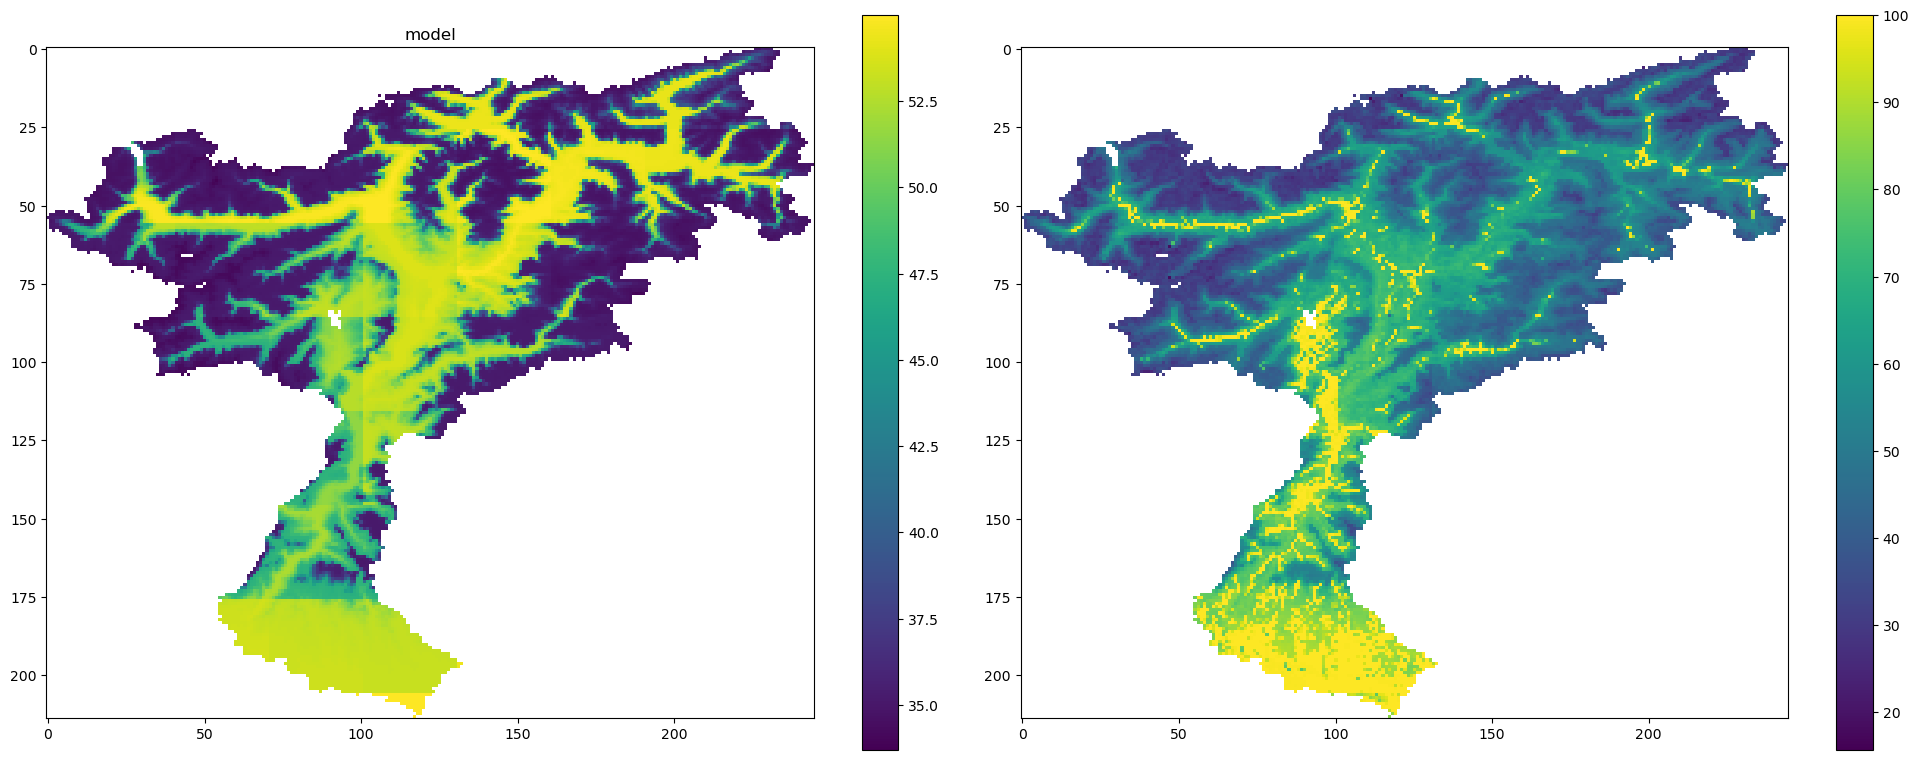

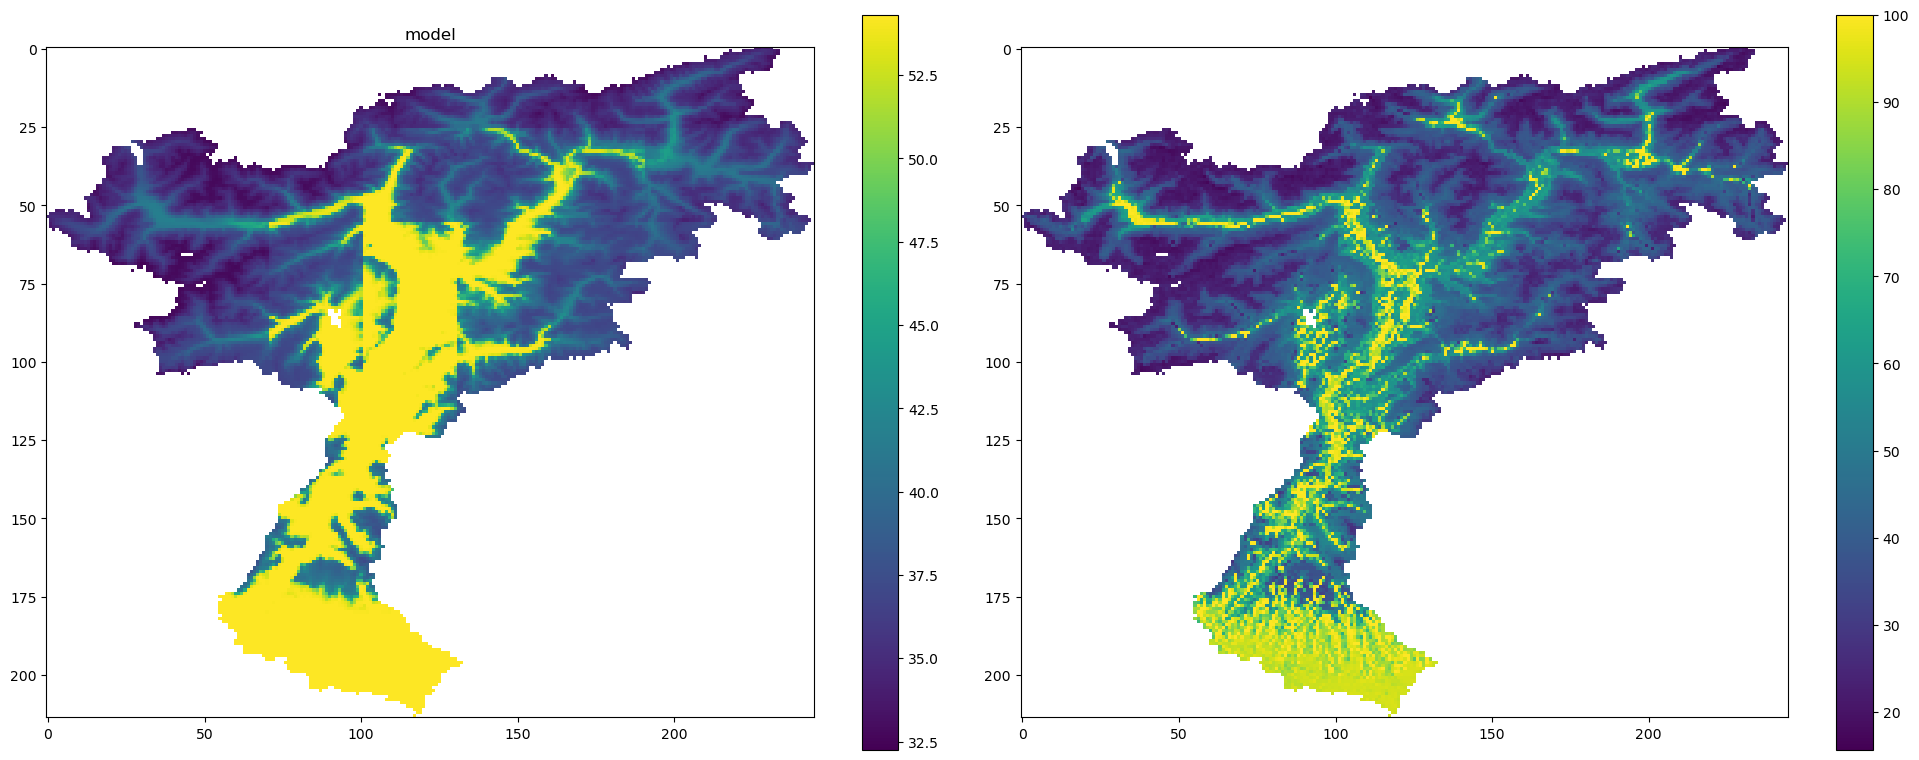

In [224]:
for i in range(500,1600,100):
    fig, ax = plt.subplots(1,2, figsize= (20,15))
    fig.subplots_adjust(hspace=0.3)
    l1 = ax[0].imshow(res.reshape(*dims["orig"][:2],  Y.shape[1], 1)[:,:,i,0])
    ax[0].set_title("model")
    fig.colorbar(l1, ax=ax[0],shrink=0.5)
    l2 = ax[1].imshow(Y.reshape(*dims["orig"][:2], Y.shape[1], 1)[:,:,i,0])
    fig.colorbar(l2, ax=ax[1],shrink=0.5)
    fig.tight_layout()

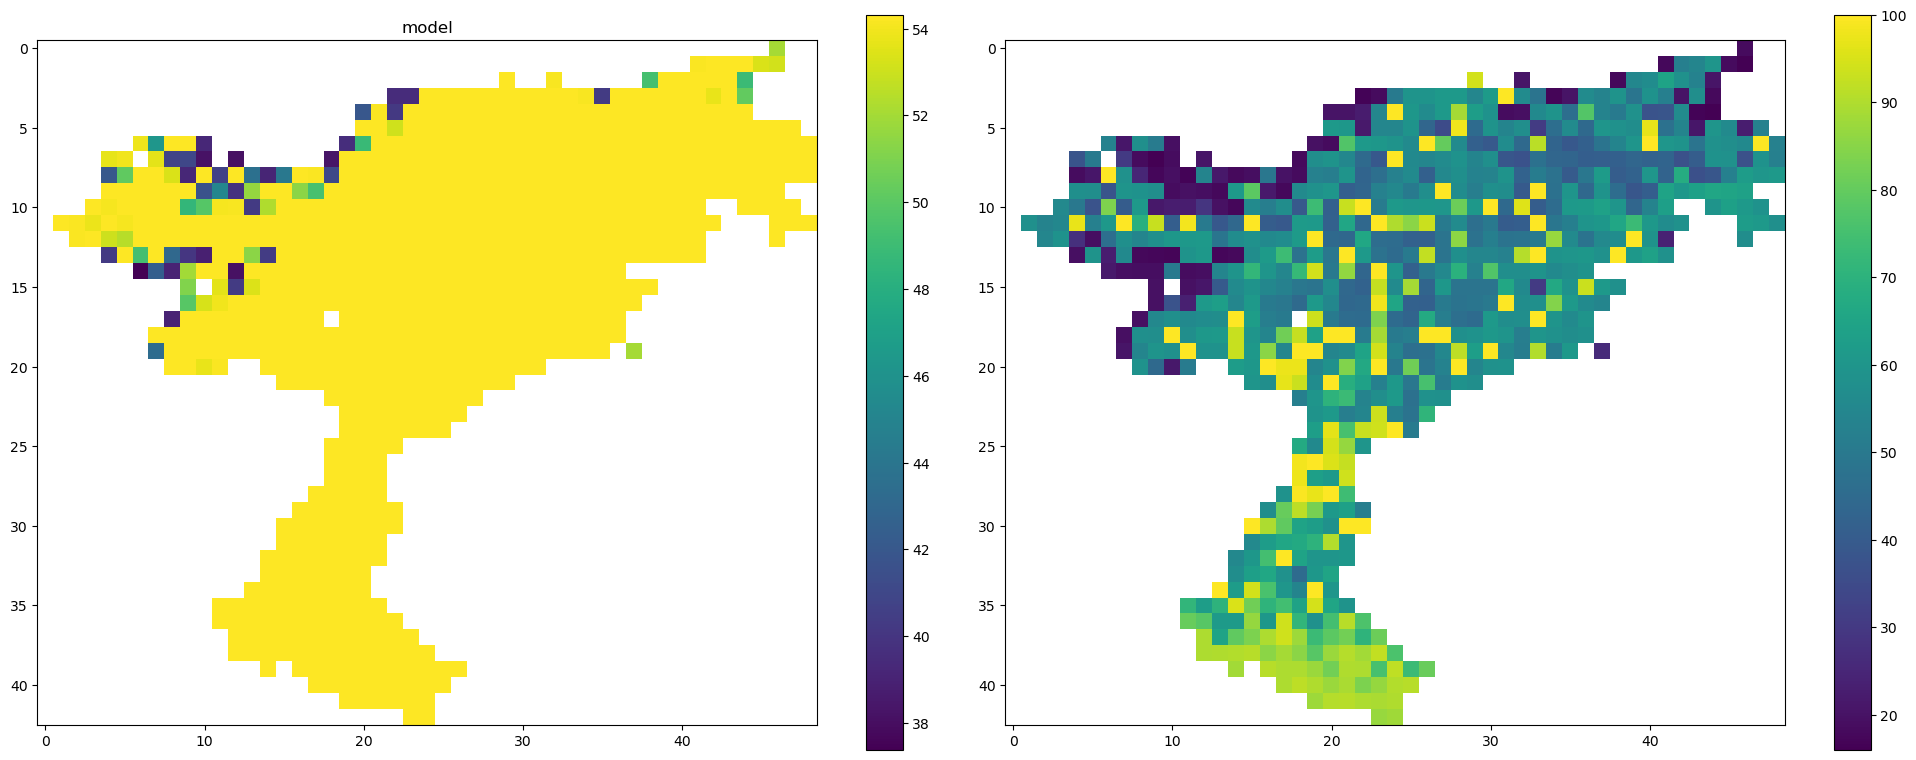

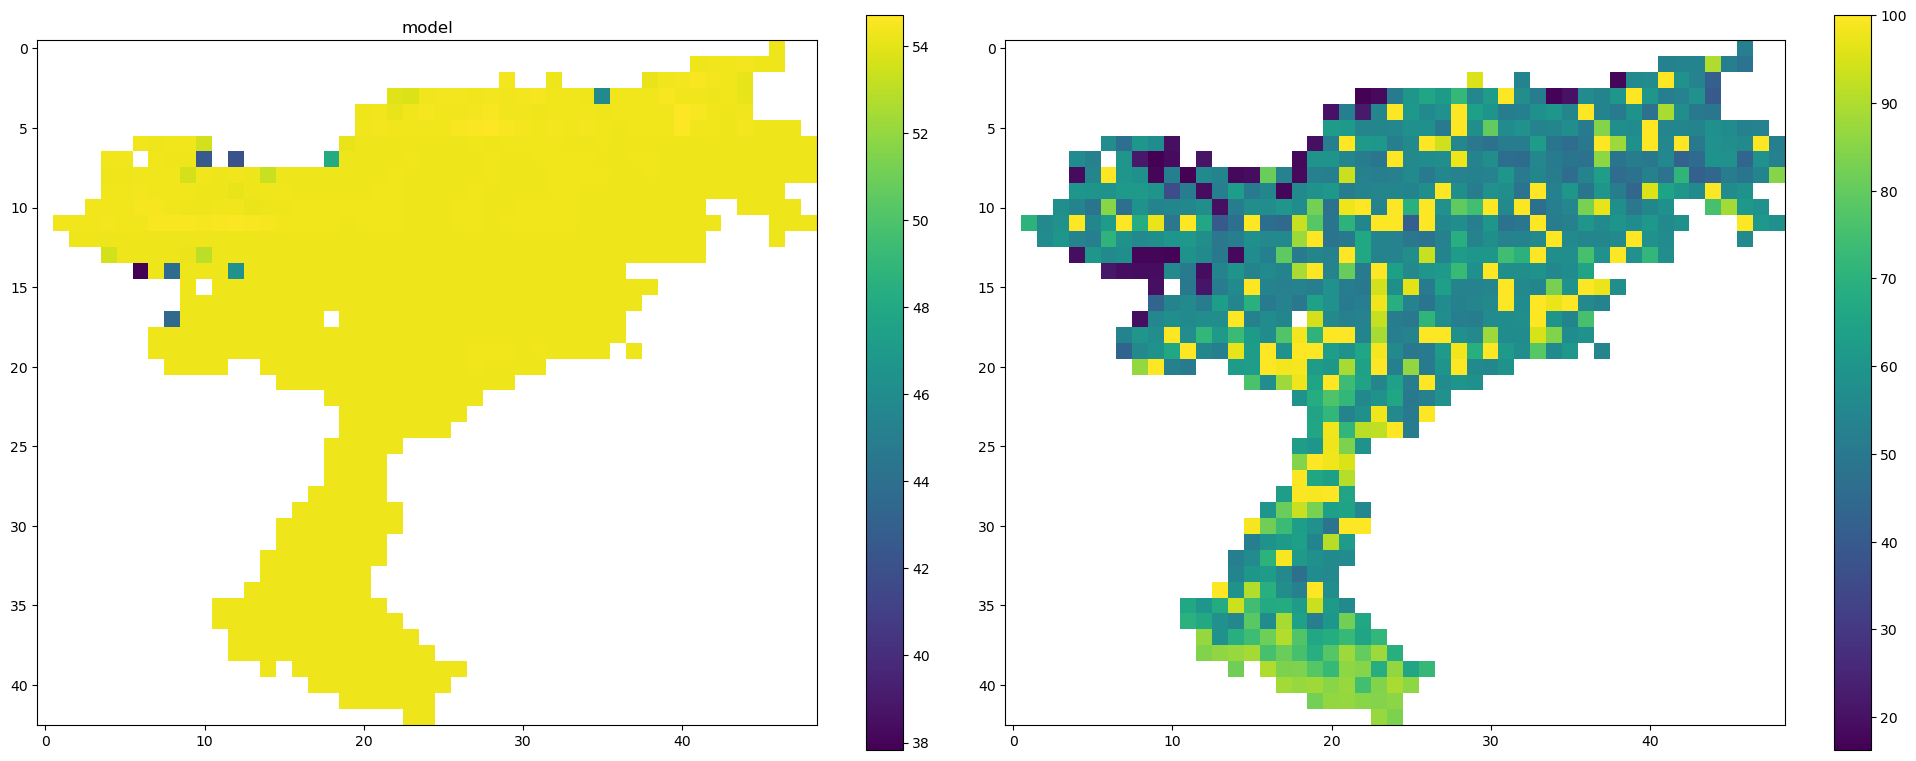

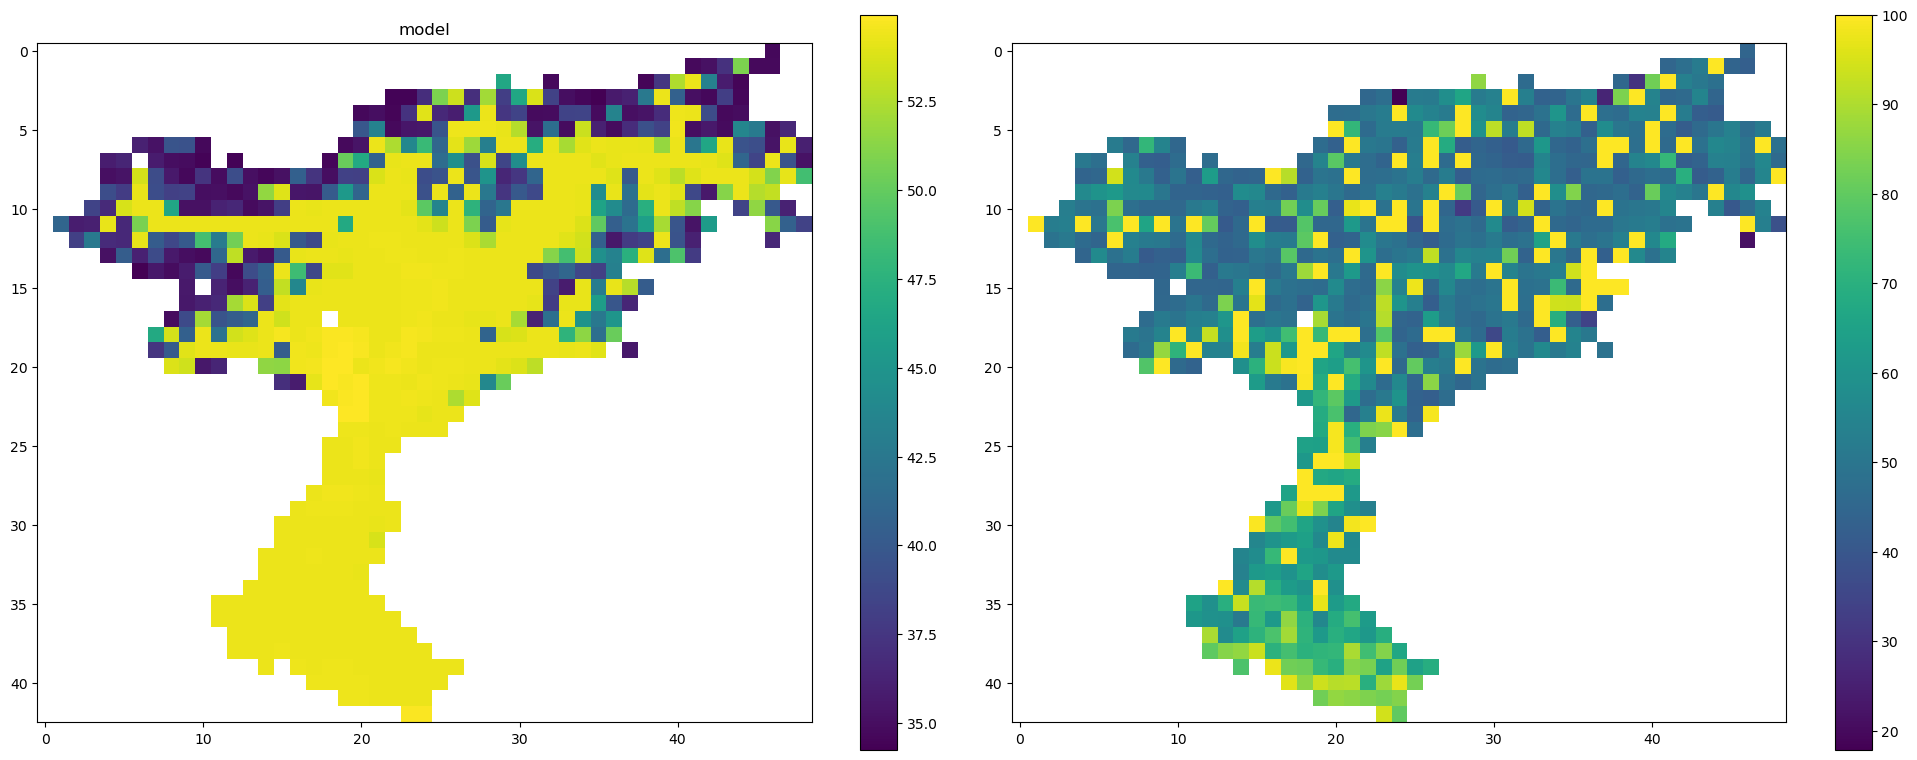

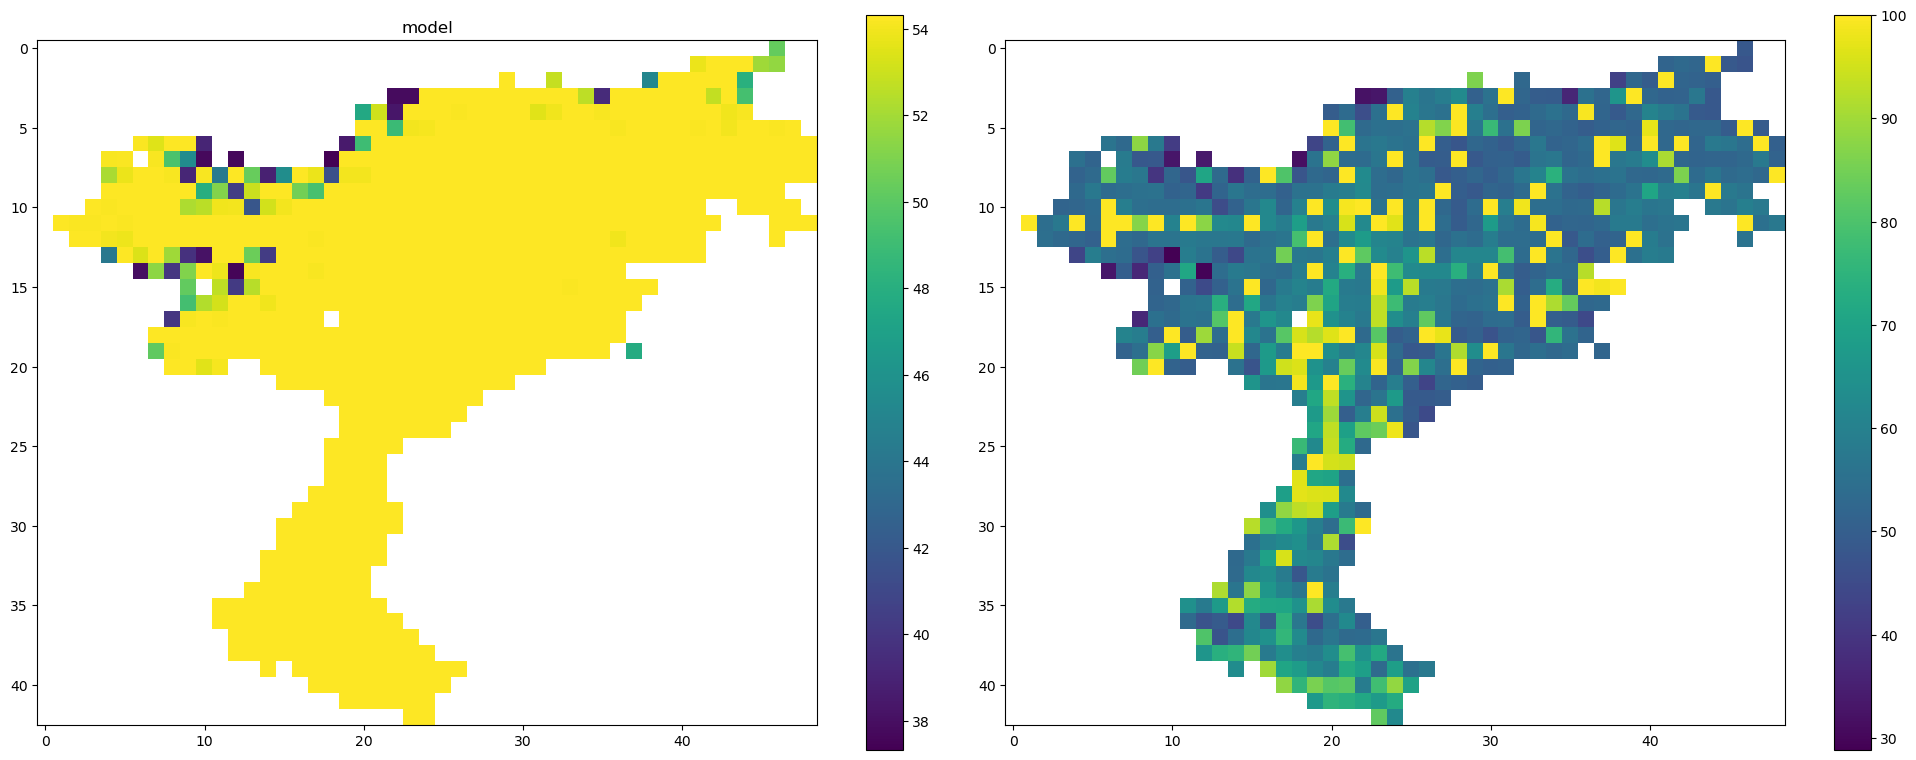

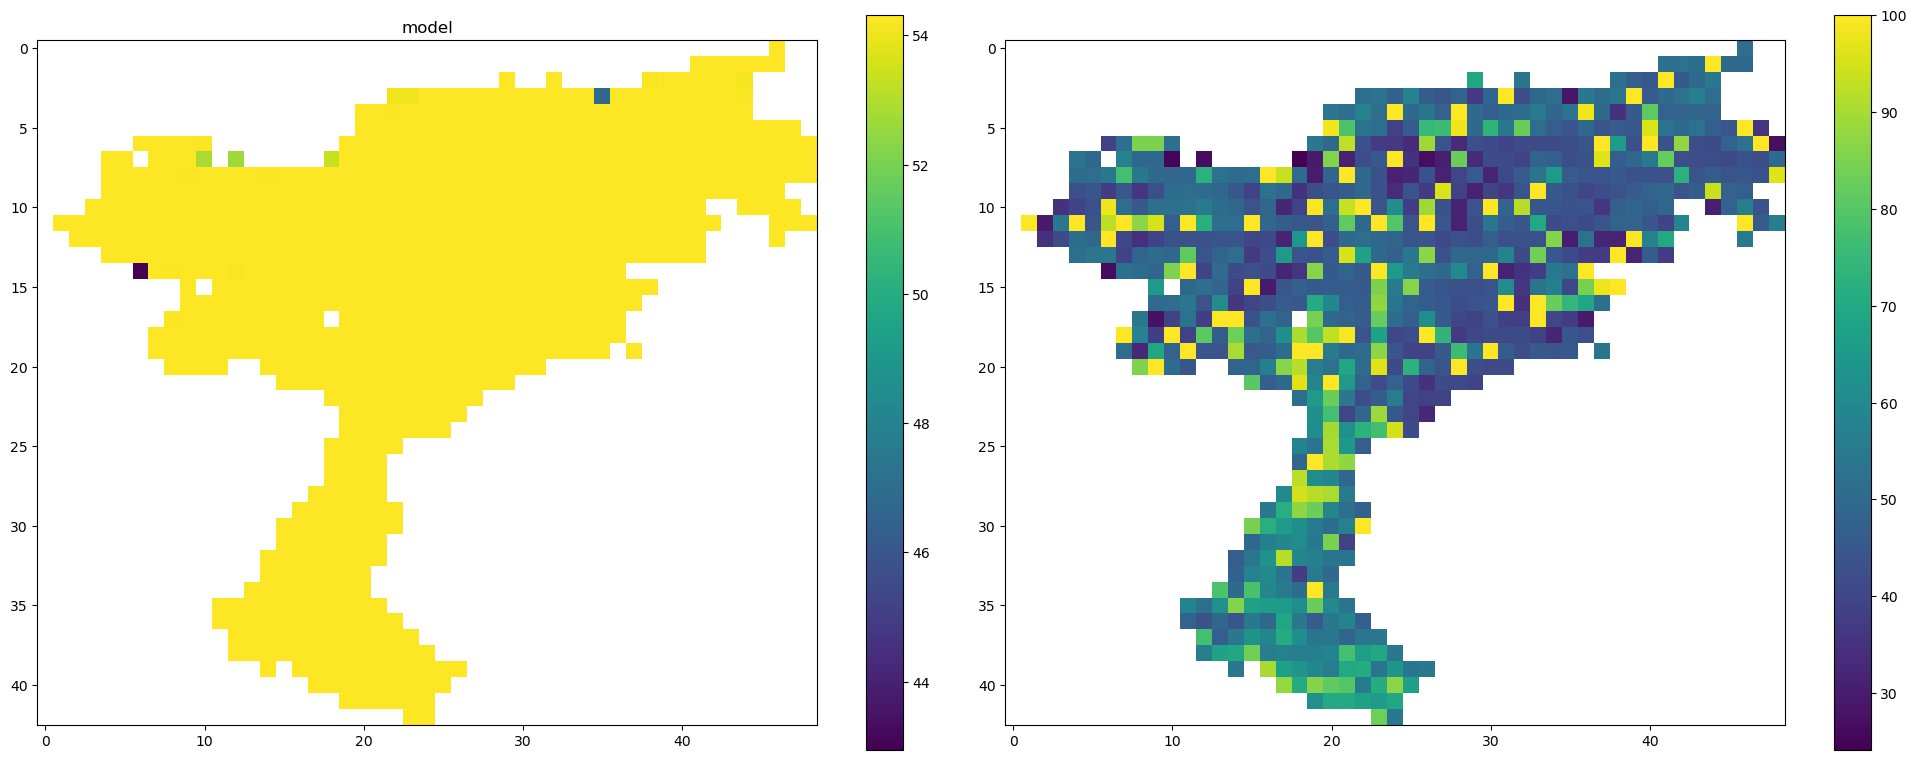

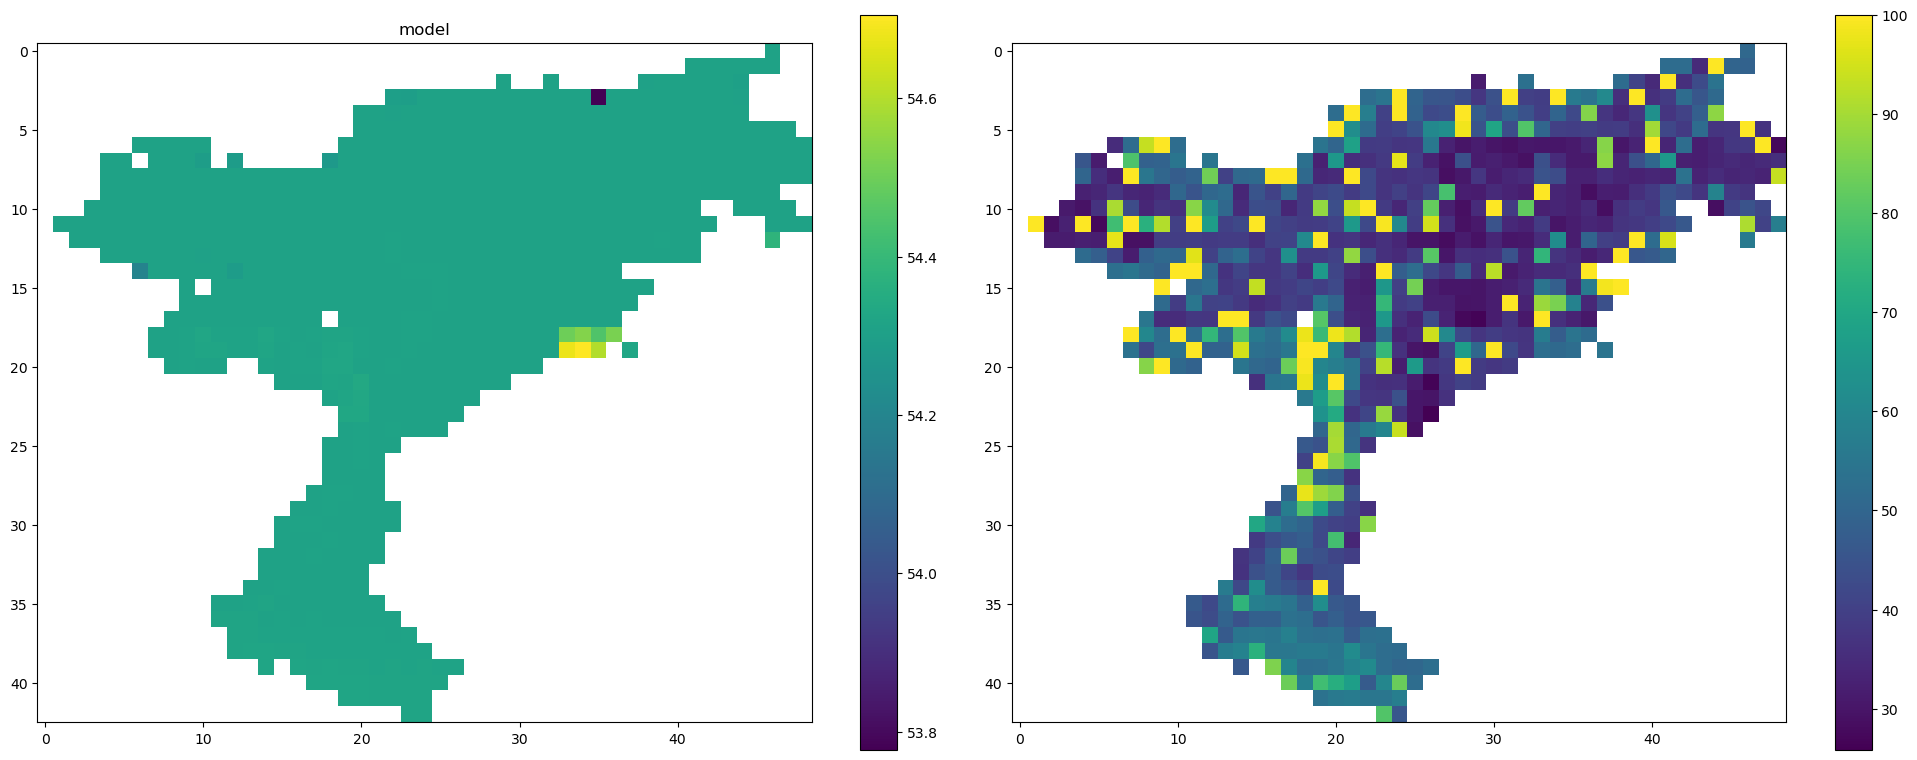

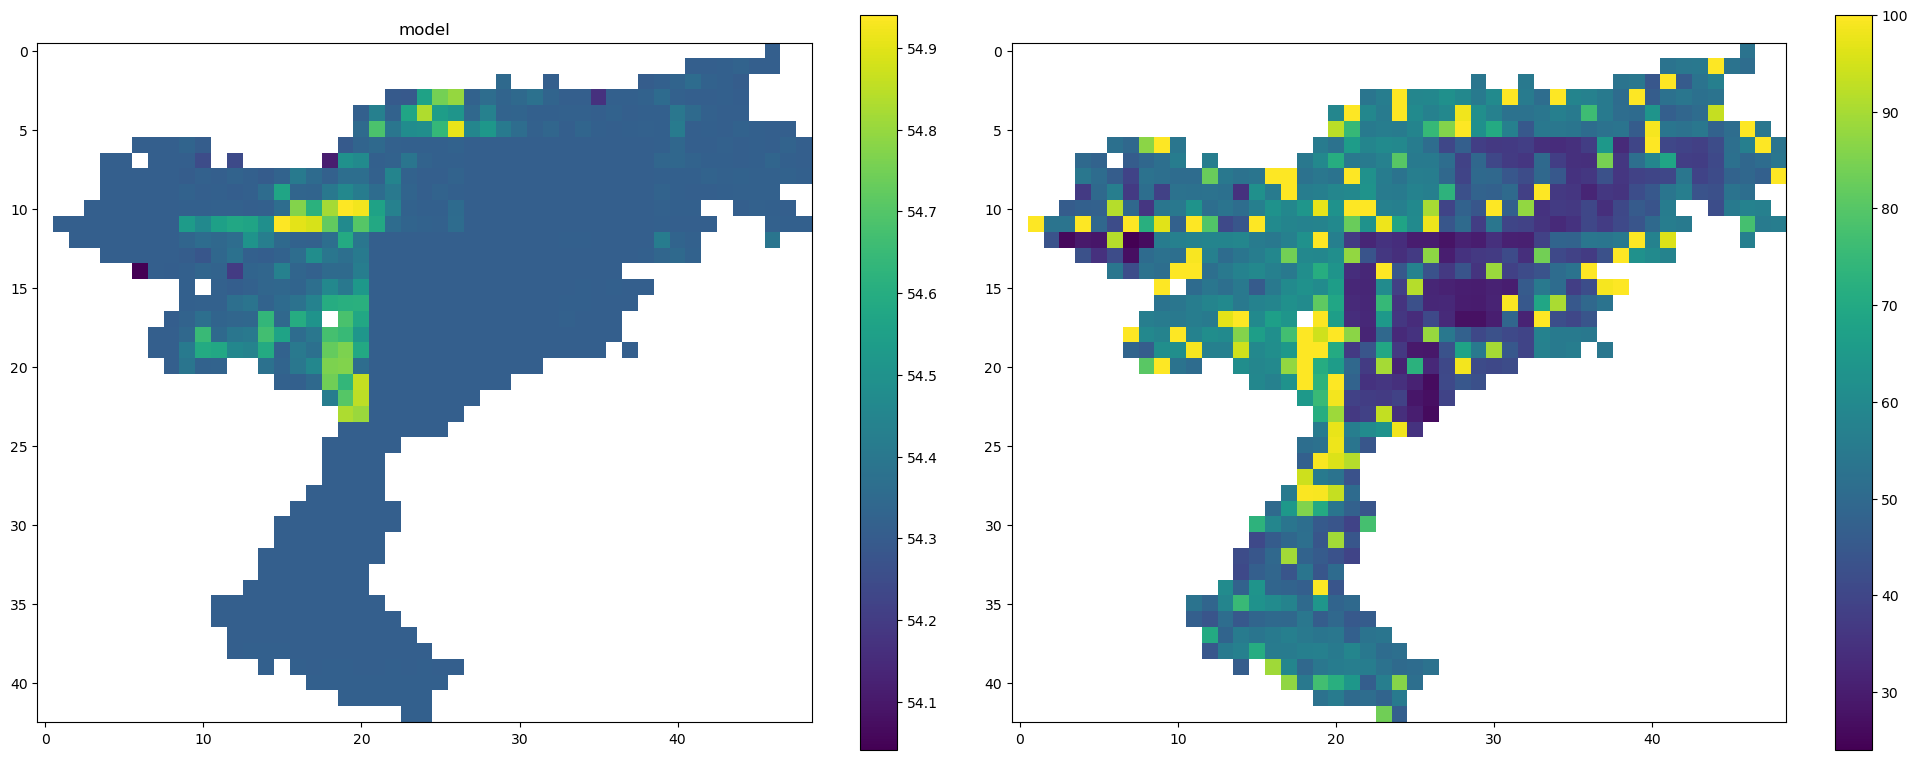

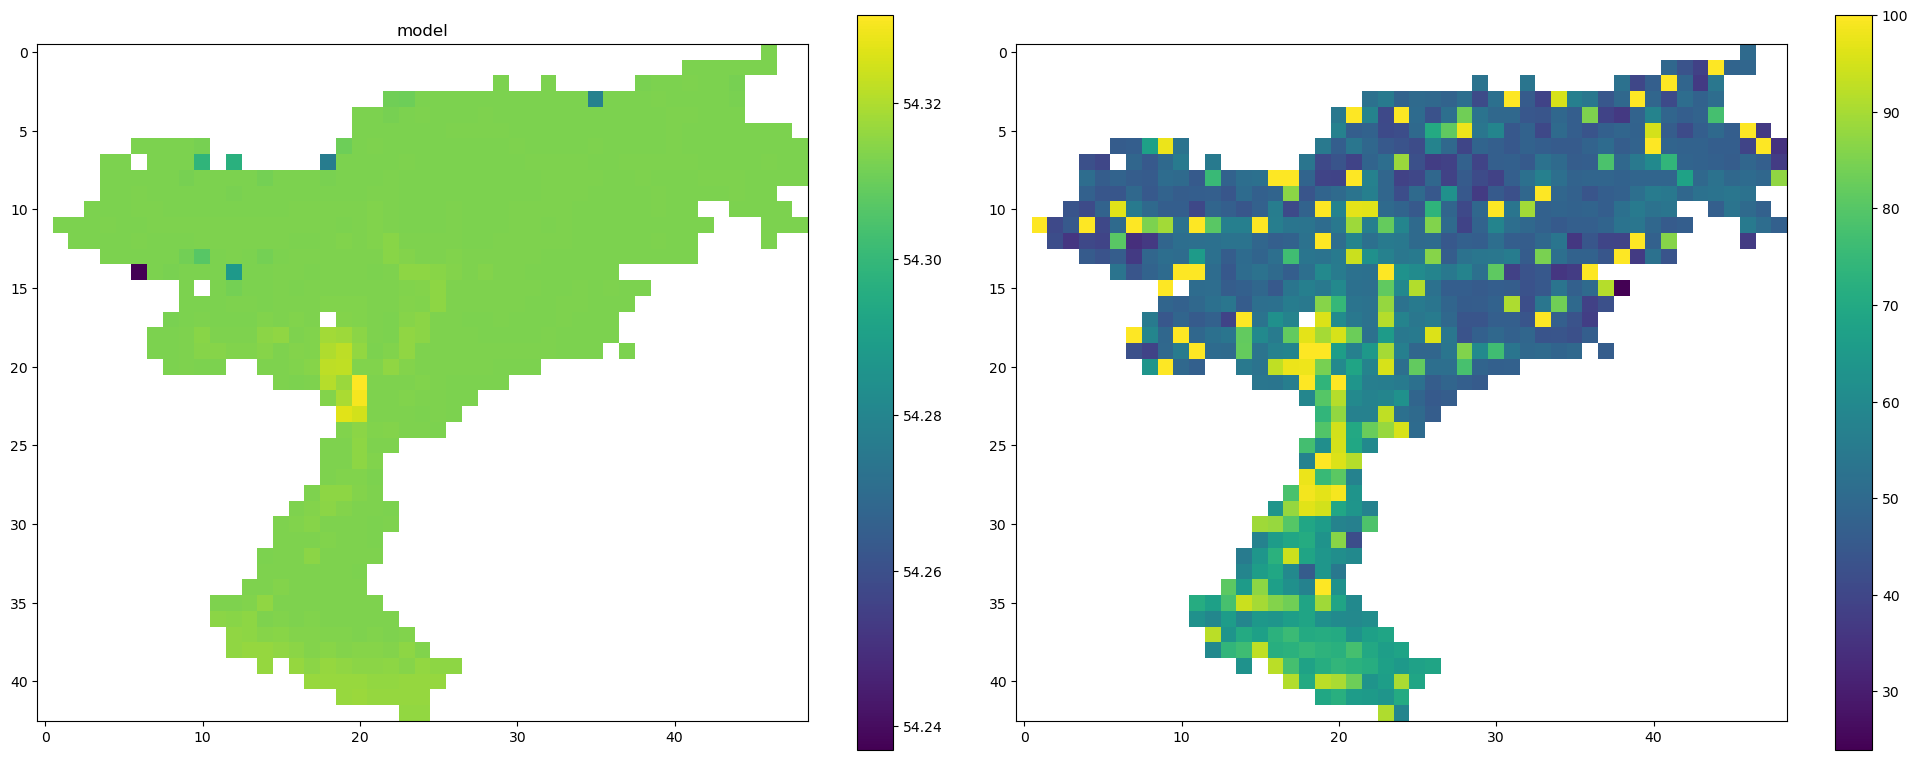

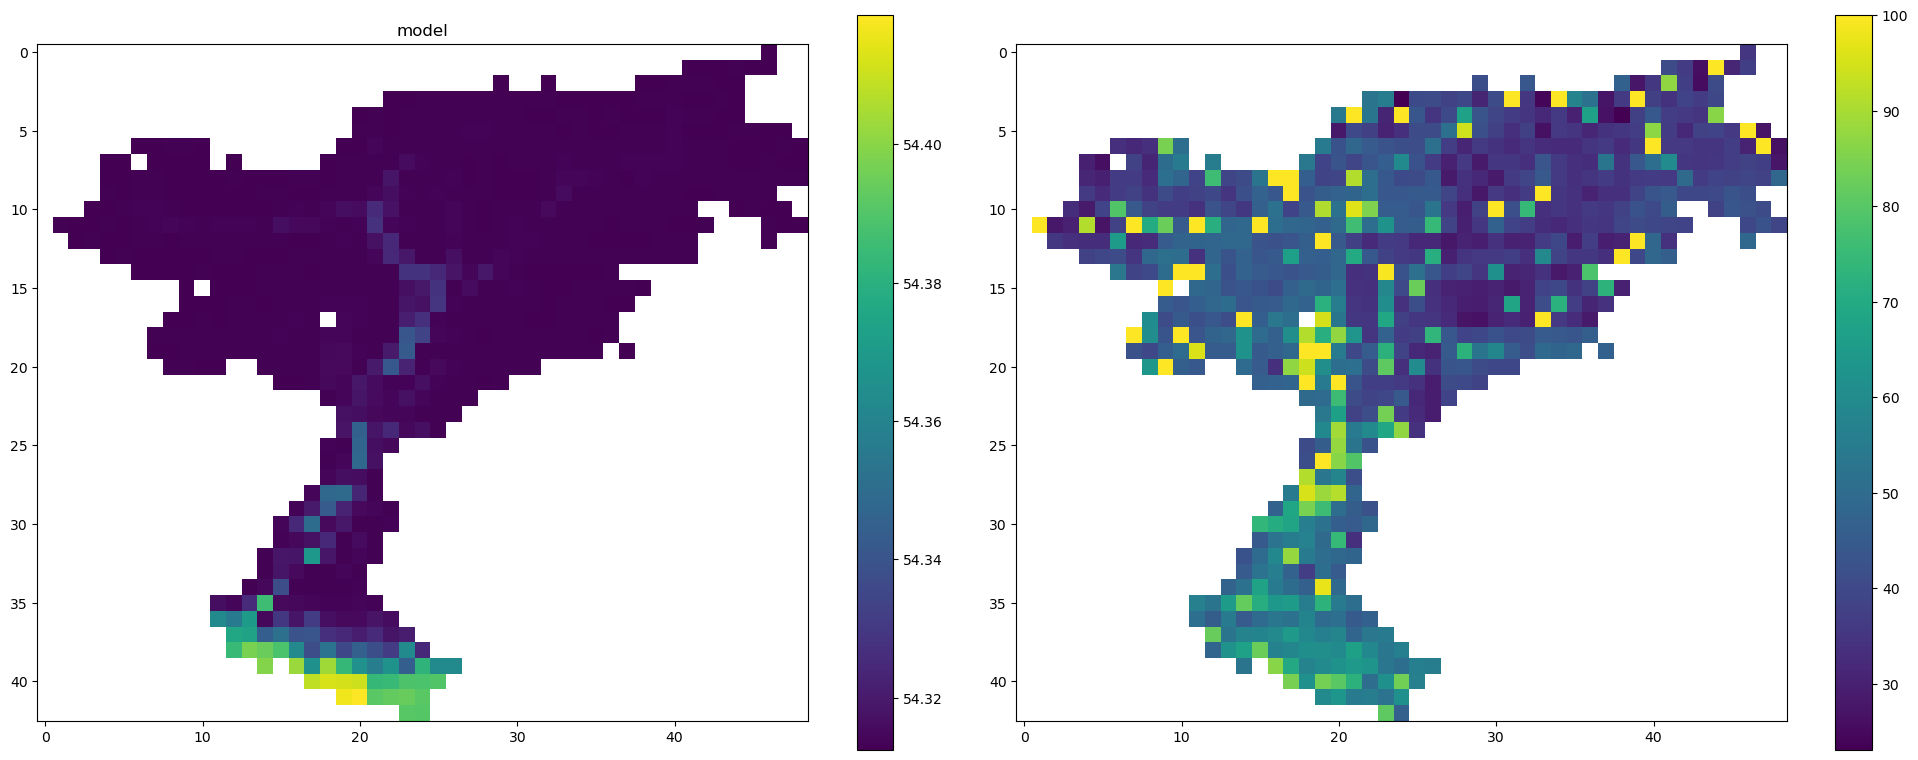

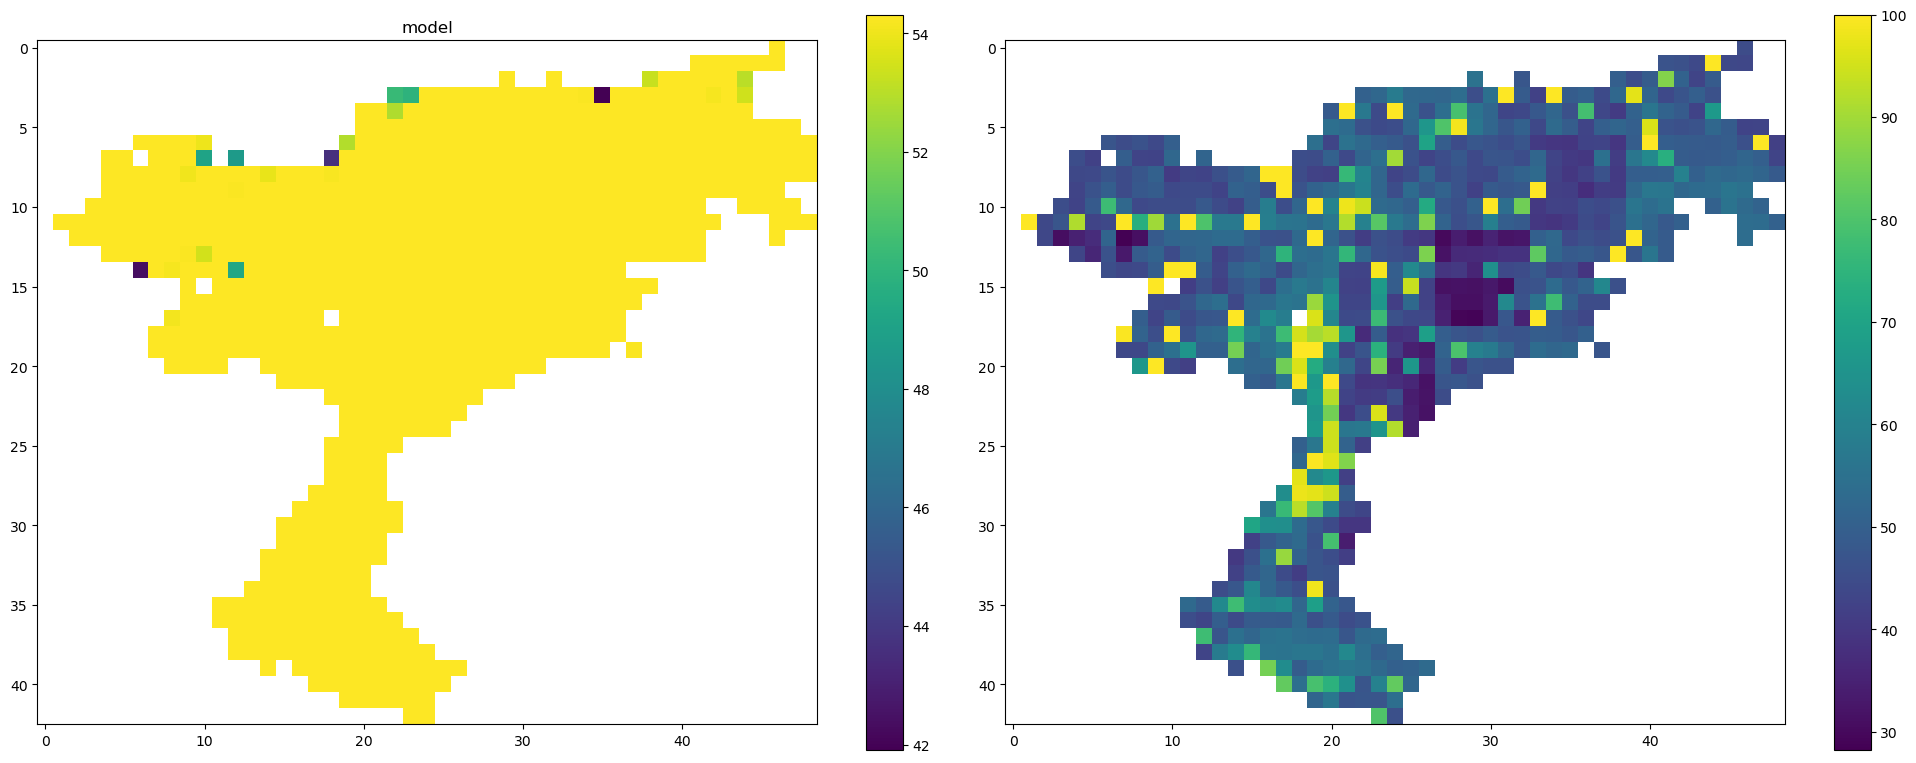

In [183]:
for i in range(500,600,10):
    fig, ax = plt.subplots(1,2, figsize= (20,15))
    fig.subplots_adjust(hspace=0.3)
    l1 = ax[0].imshow(reconstruct(res, Y.shape, idx).reshape(*dims["sampled_dims"][:2],  Y.shape[1], 1)[:,:,i,0])
    ax[0].set_title("model")
    fig.colorbar(l1, ax=ax[0],shrink=0.5)
    l2 = ax[1].imshow(Y.reshape(*dims["sampled_dims"][:2], Y.shape[1], 1)[:,:,i,0])
    fig.colorbar(l2, ax=ax[1],shrink=0.5)
    fig.tight_layout()

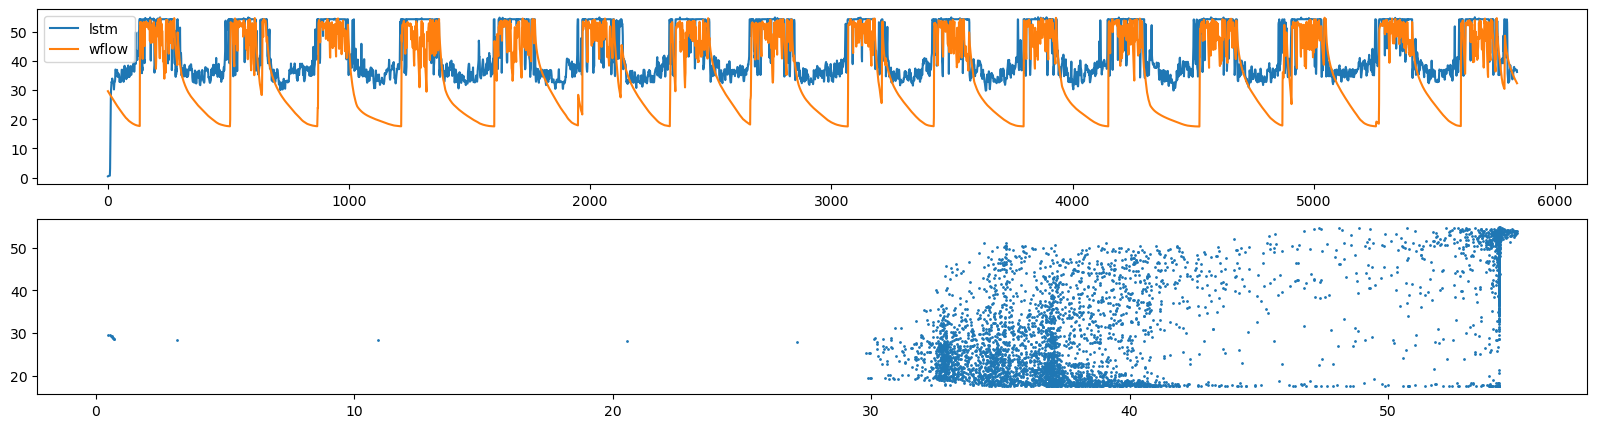

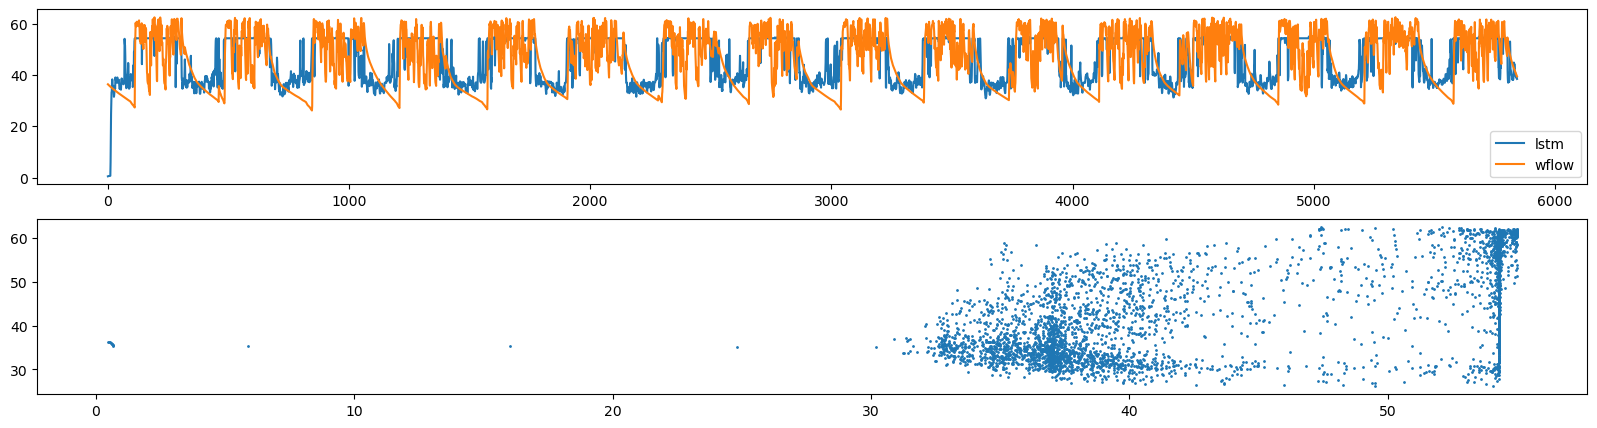

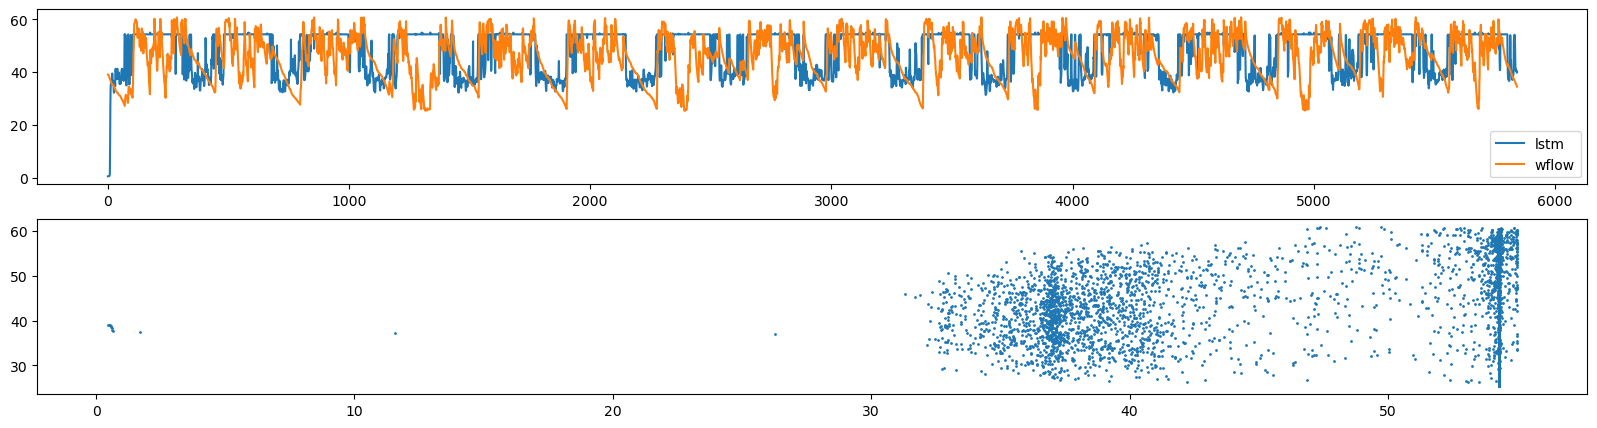

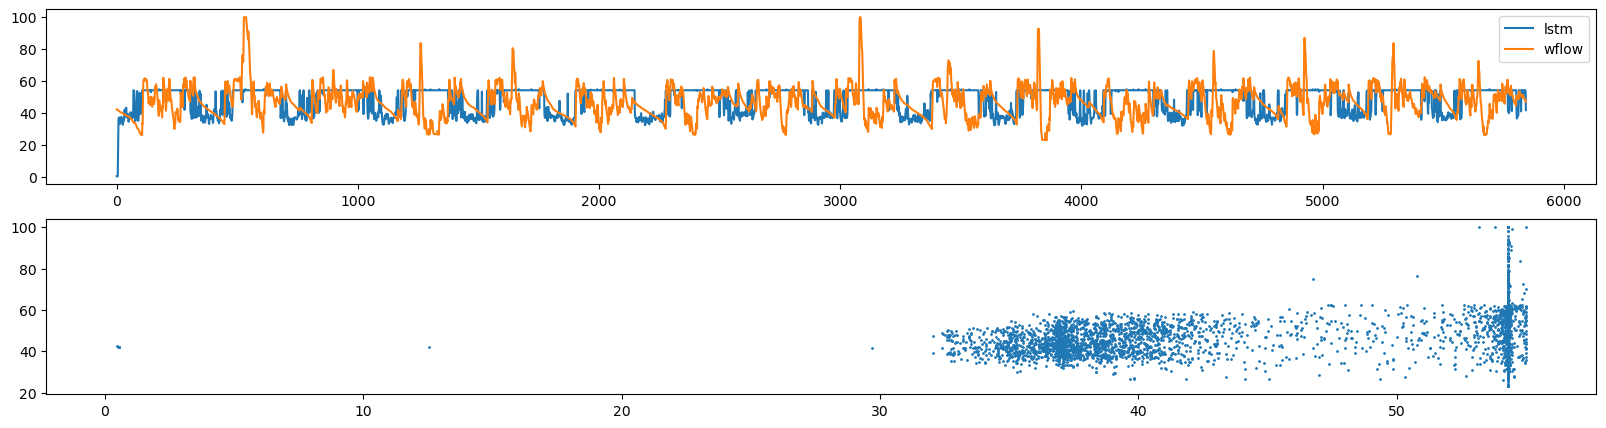

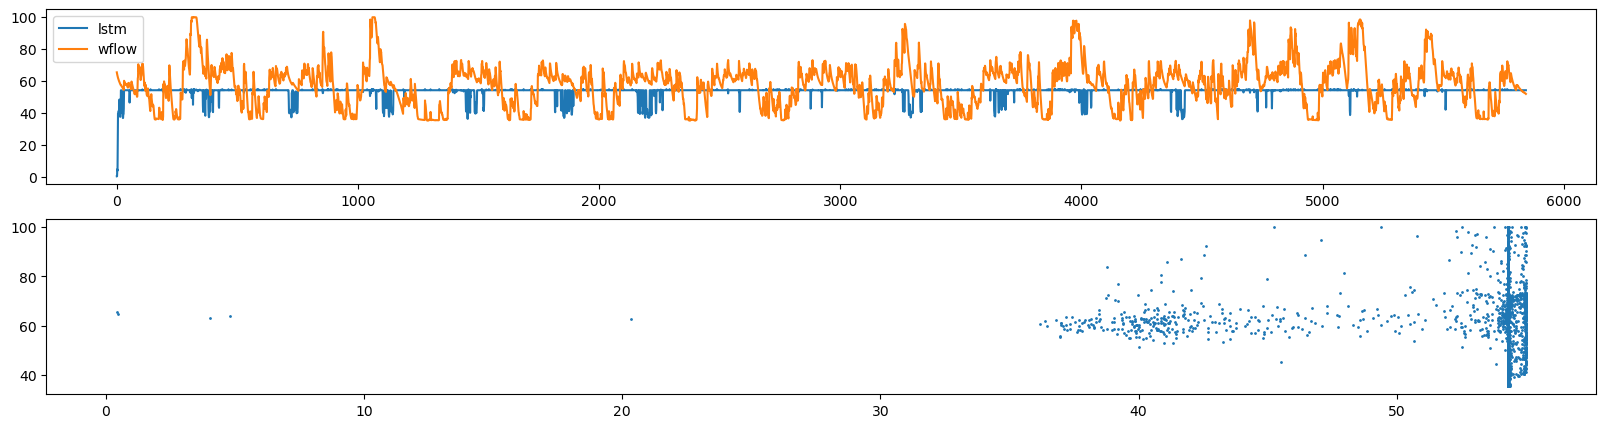

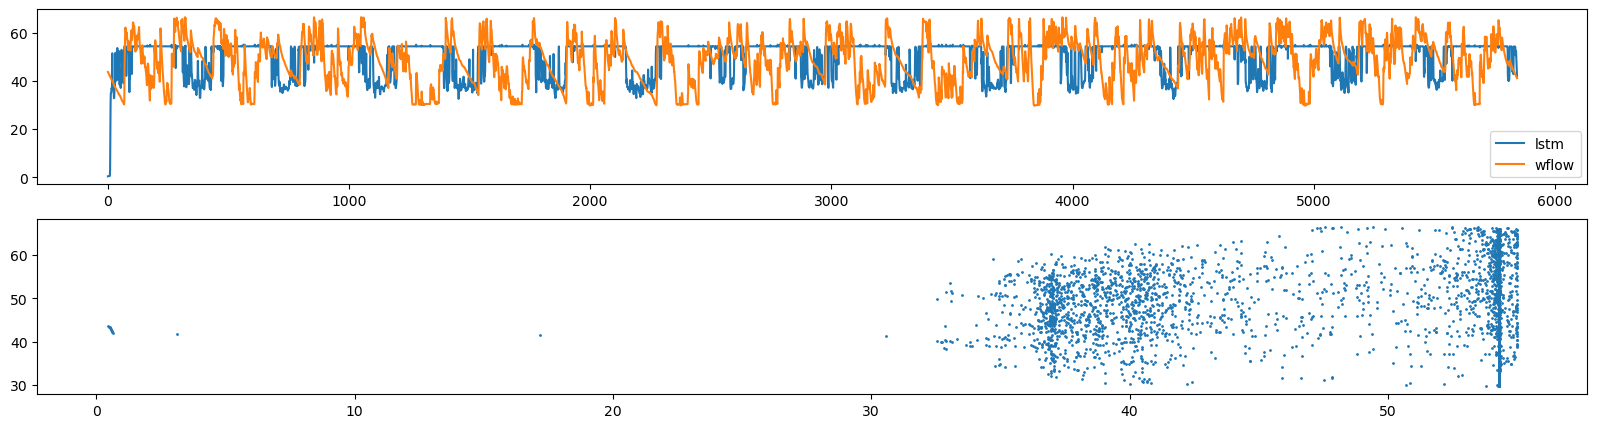

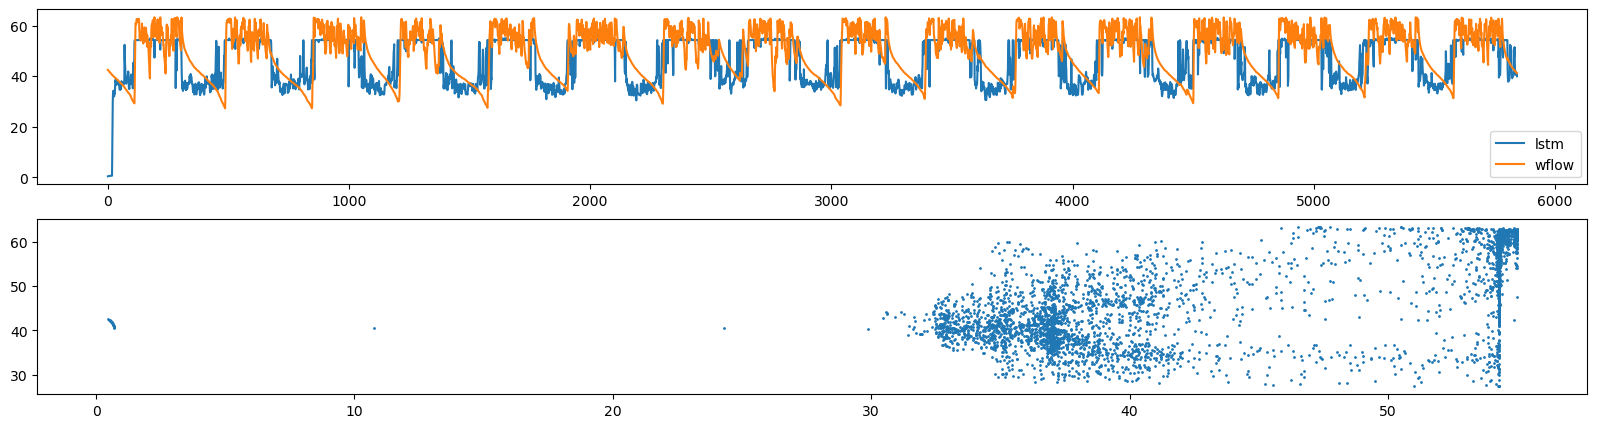

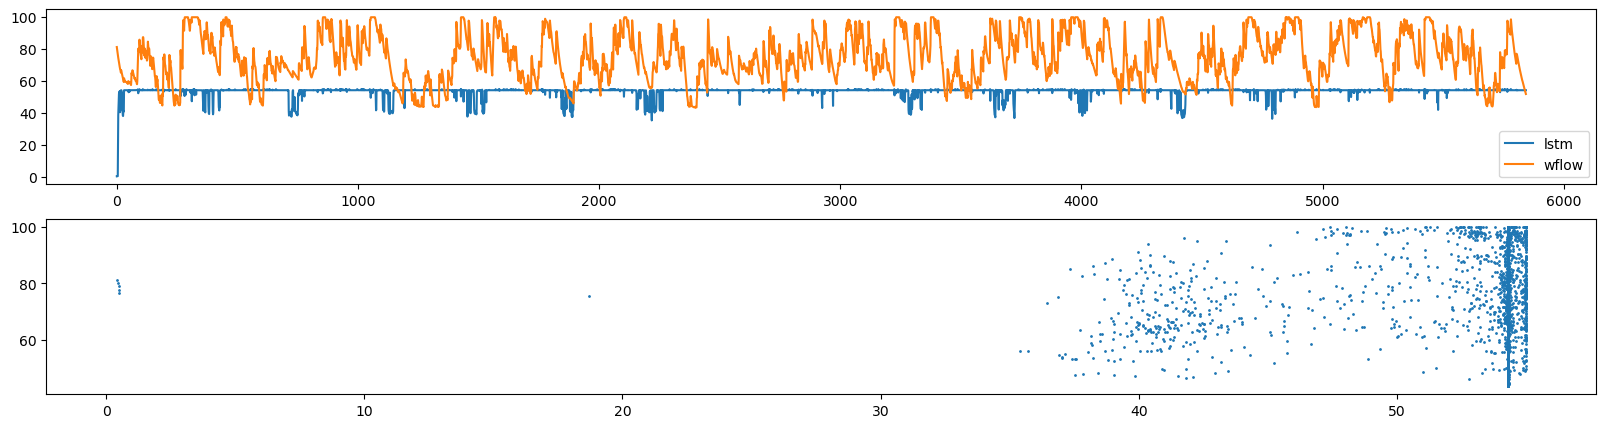

In [184]:
for i in range(1,Y_clean.shape[0],100):
    fig, axs = plt.subplots(2,1, figsize=(20,5)) 
    axs[0].plot(res[i,:,0], label ="lstm")
    axs[0].plot(Y_clean[i,:,0], label="wflow")
    axs[0].legend()
    axs[1].scatter(res[i,:,0],Y_clean[i,:,0], s=1)
    #axs[1].set_xlim(0.10,0.35)
    #axs[1].set_ylim(0.10,0.35)

In [ ]:
for i in range(1,Y_clean.shape[0],100):
    fig, axs = plt.subplots(2,1, figsize=(20,5)) 
    axs[0].plot(res[i,365:,0], label ="lstm")
    #axs[0].plot(Y_clean[i,365:,0], label="wflow")
    axs[0].legend()
    axs[1].scatter(res[i,365:,0],Y_clean[i,365:,0], s=1)
    #axs[1].set_xlim(0.10,0.35)
    #axs[1].set_ylim(0.10,0.35)

### ET

In [ ]:
set_seed(2023)

def mse_metric(output, target):
    metric_epoch = mean_squared_error(output[:,:,1], target[:,:,1], squared=False)
    return metric_epoch


# Training and validation 
path2models= "./checkpoints" #./output/kaggle/working/AI4EO/models
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
## Where to save the trained models weights 
## Set the optimization algorithms and learning rate
opt = optim.Adam(model.parameters(), lr=1e-2)

## Set the loss function
loss_fn = nn.MSELoss()

## Set the metric function - here using the same loss function 
metric_fn = mse_metric #nn.MSELoss()

## Set the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5)

## Set the training parameters
params_train={
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt"

}

model, et_loss_history ,et_metric_history = train_val(model, params_train)

In [ ]:
import matplotlib.pyplot as plt

# Extract the loss values
train_loss = et_metric_history['train']
val_loss = et_metric_history['val']

# Create a list of epochs for the x-axis (e.g., [1, 2, 3, ..., 100])
epochs = list(range(1, 101))

# Create the train and validation loss plots
plt.figure(figsize=(10, 6))
#plt.plot(epochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Validation Loss - ET')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#TEST

In [ ]:

import random
import numpy as np
import torch
# multivariate data preparation
from numpy import array
from numpy import hstack
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 
# define input sequence
in_seq1 = array([x for x in range(0,1000,100)])
in_seq2 = array([x for x in range(5,1005,100)])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))

In [ ]:
dataset.shape, len( in_seq1)

((10, 3), 10)

In [ ]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 20 # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)
    
        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 1)
        
    
    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)
    
    
    def forward(self, x):        
        batch_size, seq_len, _ = x.size()
        
        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.l_linear(x)

In [ ]:
n_features = 2 # this is number of parallel inputs
n_timesteps = 3 # this is number of timesteps
# convert dataset into input/output
X, y = split_sequences(dataset, n_timesteps)
print(X.shape, y.shape)
# create NN
mv_net = MV_LSTM(n_features,n_timesteps)
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-1)
train_episodes = 500
batch_size = 16
len(X)

(8, 3, 2) (8,)


8

In [ ]:
mv_net.train()
for t in range(train_episodes):
    for b in range(0,len(X),batch_size):
        print("ds")
        inpt = X[b:b+batch_size, :, :]
        target = y[b:b+batch_size]    
        
        x_batch = torch.tensor(inpt,dtype=torch.float32)    
        y_batch = torch.tensor(target,dtype=torch.float32)
    
        mv_net.init_hidden(x_batch.size(0))
    #    lstm_out, _ = mv_net.l_lstm(x_batch,nnet.hidden)    
    #    lstm_out.contiguous().view(x_batch.size(0),-1)
        output = mv_net(x_batch) 
        loss = criterion(output.view(-1), y_batch)  
        
        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 
    print('step : ' , t , 'loss : ' , loss.item())

ds
step :  0 loss :  1430271.25
ds
step :  1 loss :  1425743.5
ds
step :  2 loss :  1420046.25
ds
step :  3 loss :  1413525.75
ds
step :  4 loss :  1407008.75
ds
step :  5 loss :  1400850.25
ds
step :  6 loss :  1394476.0
ds
step :  7 loss :  1387970.5
ds
step :  8 loss :  1381379.25
ds
step :  9 loss :  1374730.375
ds
step :  10 loss :  1368042.125
ds
step :  11 loss :  1361329.0
ds
step :  12 loss :  1354603.25
ds
step :  13 loss :  1347874.125
ds
step :  14 loss :  1341148.75
ds
step :  15 loss :  1334431.875
ds
step :  16 loss :  1324443.875
ds
step :  17 loss :  1317518.25
ds
step :  18 loss :  1310532.375
ds
step :  19 loss :  1303513.625
ds
step :  20 loss :  1296477.375
ds
step :  21 loss :  1289434.875
ds
step :  22 loss :  1282393.875
ds
step :  23 loss :  1275360.625
ds
step :  24 loss :  1268339.875
ds
step :  25 loss :  1261335.625
ds
step :  26 loss :  1254350.875
ds
step :  27 loss :  1247388.25
ds
step :  28 loss :  1240450.0
ds
step :  29 loss :  1233538.125
ds
step : 